# 1. Timeseries Data Preprocessing: Day-Ahead prices

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
da_raw = pd.read_csv('./raw_data/EPEX_spot_DA_auction_hour_prices_20070720-20170831.csv',
                     index_col=0, parse_dates=True)
da_raw.head(n=5)

,DA_price
2007-07-20 00:00:00,25.69
2007-07-20 01:00:00,26.45
2007-07-20 02:00:00,24.33
2007-07-20 03:00:00,23.57
2007-07-20 04:00:00,18.96


In [3]:
da_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
DA_price,88704.0,41.295654,21.352333,-500.02,29.0,38.64,50.97,821.9


In [4]:
# check if their are any gaps within the data
any(da_raw.dropna().index.to_series().diff() > pd.Timedelta('01:00:00'))

False

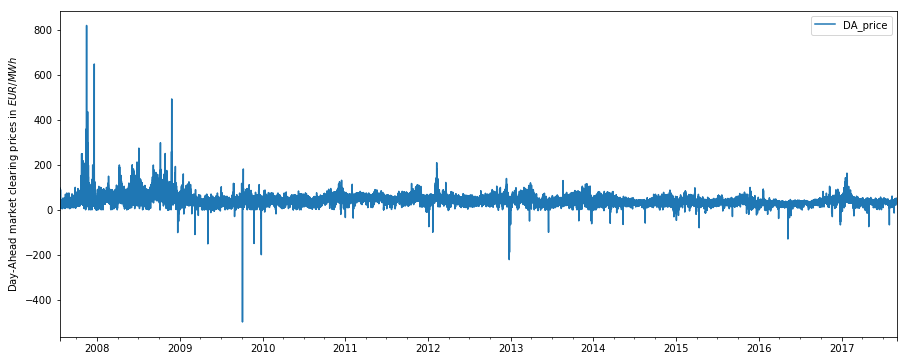

In [5]:
ax = da_raw.plot(figsize=(15, 6))
ax.set_ylabel('Day-Ahead market clearing prices in $EUR/MWh$')

__Analysis__

We can see that there are extreme price peaks in the late 2007 and extreme price lows in late 2009. These price peaks are most likely due to market flaws in the early days of Day-Ahead trading. We can see that the price range gets substantially smaller in the later years. These extreme prices should be removed to avoid problems when scaling the data to a range between 0 and 1 for input into a regression algorithm.

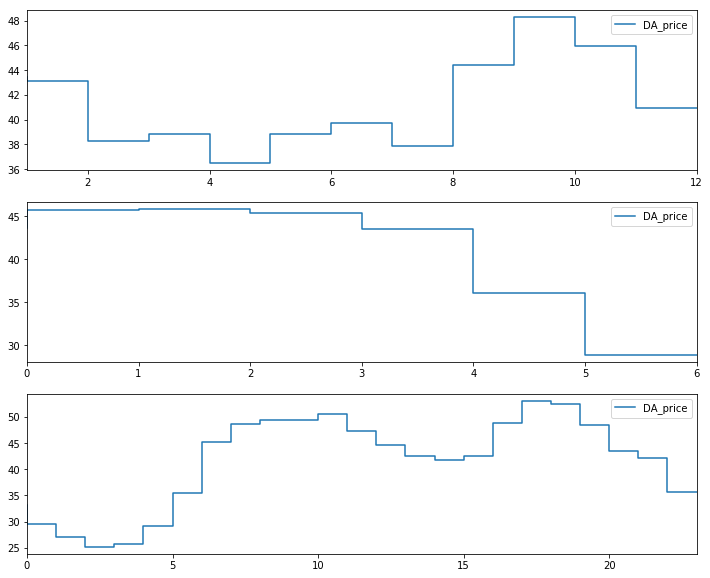

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
da_raw.groupby(da_raw.index.month).mean().plot(ax=ax1, drawstyle='steps')
da_raw.groupby(da_raw.index.dayofweek).mean().plot(ax=ax2, drawstyle='steps')
da_raw.groupby(da_raw.index.hour).mean().plot(ax=ax3, drawstyle='steps')

__Analysis__

tbd

In [3]:
# keep raw data of the test set for model evaluation
test_raw = da_raw['2017']

In [4]:
da_prep = pd.DataFrame(index=da_raw.index)

In [5]:
# calculate quantiles and inter-quantile range of the data
q75 = da_raw['DA_price'].quantile(.75)
q25 = da_raw['DA_price'].quantile(.25)
IQR = q75 - q25

# values larger (smaller) than q75 (q25) plus 'tol' times IQR get replaces by that value
tol = 3
da_prep['DA_price'] = da_raw['DA_price'].apply(lambda x: q75 + tol * IQR if (x > q75 + tol * IQR) else x)
da_prep['DA_price'] = da_prep['DA_price'].apply(lambda x: q25 - tol * IQR if (x < q75 - tol * IQR) else x)

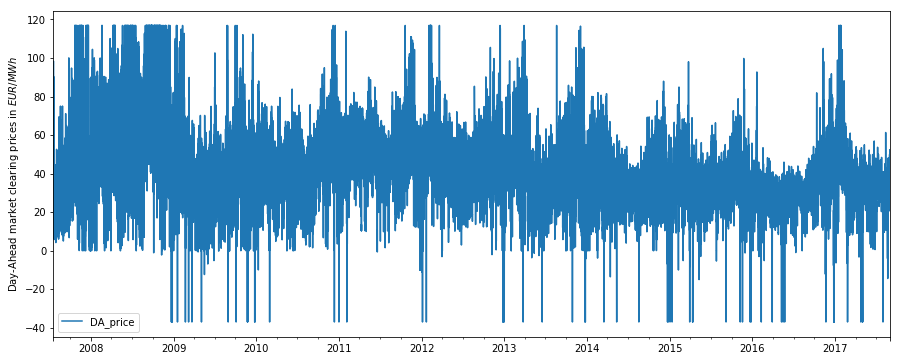

In [10]:
ax = da_prep.plot(figsize=(15, 6))
ax.set_ylabel('Day-Ahead market clearing prices in $EUR/MWh$')

__Analysis__

The range of the prices now looks much more appropriate to be scaled to 0-1 values. When scaling, the data will now be much more spread out instead of concentrating around some median value, as it would have been the case when the outliers would not have been removed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f44257194e0>]], dtype=object)

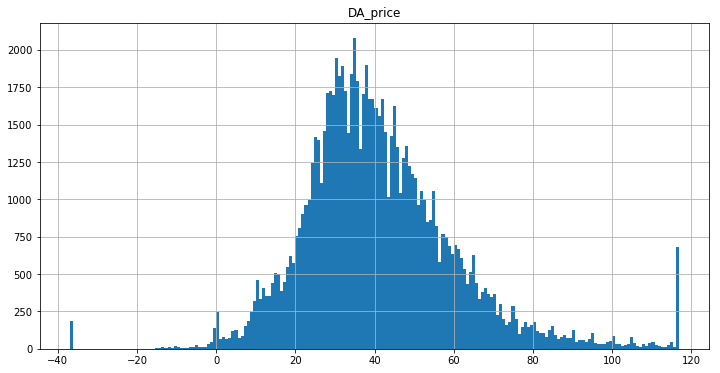

In [11]:
da_prep.hist(bins=200, figsize=(12, 6))

In [6]:
# scale data to range between 0 and 1
da_scaler = MinMaxScaler()
da_prep['DA_price'] = da_scaler.fit_transform(da_prep['DA_price'].values.reshape(-1, 1))

In [7]:
# include time lags of timeseries data for 1 week = 7 * 24h = 168h
lags = 168
for l in range(1, lags+1):
    da_prep['l_{}'.format(l)] = da_prep['DA_price'].shift(l)

In [8]:
# drop missing data entries that result from the lagging step (no lagged data available for first 168 days of year)
da_prep.dropna(inplace=True)
da_prep.head(n=5)

,DA_price,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,l_159,l_160,l_161,l_162,l_163,l_164,l_165,l_166,l_167,l_168
2007-07-27 00:00:00,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,0.435529,0.432083,0.454516,0.455231,...,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288,0.393264,0.398205,0.411990,0.407049
2007-07-27 01:00:00,0.369920,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,0.435529,0.432083,0.454516,...,0.858053,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288,0.393264,0.398205,0.411990
2007-07-27 02:00:00,0.343325,0.369920,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,0.435529,0.432083,...,0.880031,0.858053,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288,0.393264,0.398205
2007-07-27 03:00:00,0.330451,0.343325,0.369920,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,0.435529,...,0.760518,0.880031,0.858053,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288,0.393264
2007-07-27 04:00:00,0.300800,0.330451,0.343325,0.369920,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,...,0.578711,0.760518,0.880031,0.858053,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288


In [9]:
# create feature and label dataframes
prelim_features = da_prep.drop('DA_price', axis=1)
prelim_labels = pd.DataFrame(da_prep['DA_price'])

In [10]:
# format labels to 24 hour output range
for i in range(0, 24):
    prelim_labels['t_{}'.format(i)] = prelim_labels['DA_price'].shift(-i)
prelim_labels.drop('DA_price', axis=1, inplace=True)

In [11]:
# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.hour == 0]
features = prelim_features[prelim_features.index.hour == 0]

In [12]:
features_train = features[:'2016']
features_test = features['2017':]
labels_train = labels[:'2016']

In [13]:
samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 168

In [14]:
# convert pandas data frames to numpy ndarrays
features_train = features_train.as_matrix().reshape(samples_train, timesteps, 1)
features_test = features_test.as_matrix().reshape(samples_test, timesteps, 1)
labels_train = labels_train.as_matrix()

In [15]:
# check for correct data shape
features_train.shape, labels_train.shape

((3446, 168, 1), (3446, 24))

# 2. Timeseries Model: Experimenting with structures

In [17]:
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

Using TensorFlow backend.


In [18]:
# split into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(features_train, labels_train, test_size=0.2, random_state=7)

## Benchmark models

### Naive benchmark models

In [19]:
benchmark_results = pd.DataFrame(index=test_raw.index)

In [20]:
benchmark_results['last_day'] = da_raw.shift(24)['2017']

In [21]:
benchmark_results['last_week'] = da_raw.shift(24*7)['2017']

In [22]:
benchmark_results['2_week_average'] = pd.concat([da_raw.shift(24 * w) for w in range(1, 3)], axis=1).mean(axis=1)['2017']

In [23]:
benchmark_results['4_week_average'] = pd.concat([da_raw.shift(24 * w) for w in range(1, 5)], axis=1).mean(axis=1)['2017']

In [24]:
for col in benchmark_results.columns:
    pred = benchmark_results[col].as_matrix()
    true = test_raw.DA_price.as_matrix()
    print('MAE of {} benchmark model: '.format(col), mean_absolute_error(y_pred=pred, y_true=true))

MAE of last_day benchmark model:  8.5257441701
MAE of last_week benchmark model:  9.13819101509
MAE of 2_week_average benchmark model:  8.97544495885
MAE of 4_week_average benchmark model:  9.17504458162


### Simple linear models

In [30]:
lin_input_layer = Input(shape=(X_train.shape[1],))
x = Dense(24)(lin_input_layer)

model = Model(inputs=[lin_input_layer], outputs=[x])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 168)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                4056      
Total params: 4,056
Trainable params: 4,056
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss='mse', optimizer='adam')
checkpoint = ModelCheckpoint('./models/timeseries_linear_only.hdf5', save_best_only=True)
hist = model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train,
                 validation_data=(X_valid.reshape(X_valid.shape[0], X_valid.shape[1]), y_valid),
                 callbacks=[checkpoint], 
                 verbose=0, batch_size=50, epochs=200)

best = load_model('./models/timeseries_linear_only.hdf5')
pred = best.predict(features_test.reshape(features_test.shape[0], features_test.shape[1]))
pred = da_scaler.inverse_transform(pred.flatten().reshape(-1, 1))
index = da_prep[da_prep.index.year == 2017].index
results = pd.DataFrame({'pred':pred.flatten(), 'true':test_raw.DA_price}, index=index)

In [32]:
print('MAE : ', mean_absolute_error(y_pred=pred, y_true=test_raw.DA_price.as_matrix()))

MAE :  6.0996195546


In [33]:
lin_input_layer = Input(shape=(X_train.shape[1],))
x = Dense(64)(lin_input_layer)
x = Dense(24)(x)

model = Model(inputs=[lin_input_layer], outputs=[x])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 168)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                10816     
_________________________________________________________________
dense_3 (Dense)              (None, 24)                1560      
Total params: 12,376
Trainable params: 12,376
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss='mse', optimizer='adam')
checkpoint = ModelCheckpoint('./models/timeseries_linear_only.hdf5', save_best_only=True)
hist = model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train,
                 validation_data=(X_valid.reshape(X_valid.shape[0], X_valid.shape[1]), y_valid),
                 callbacks=[checkpoint], 
                 verbose=0, batch_size=50, epochs=200)

best = load_model('./models/timeseries_linear_only.hdf5')
pred = best.predict(features_test.reshape(features_test.shape[0], features_test.shape[1]))
pred = da_scaler.inverse_transform(pred.flatten().reshape(-1, 1))
index = da_prep[da_prep.index.year == 2017].index
results = pd.DataFrame({'pred':pred.flatten(), 'true':test_raw.DA_price}, index=index)

In [35]:
print('MAE : ', mean_absolute_error(y_pred=pred, y_true=test_raw.DA_price.as_matrix()))

MAE :  5.8387074386


## First experimental architecture

In [49]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(input_layer)
x = LSTM(32, recurrent_activation='relu')(x)
output_layer = Dense(24)(x)
model = Model(inputs=[input_layer], outputs=[output_layer])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 168, 1)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 7, 64)             1600      
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_29 (Dense)             (None, 24)                792       
Total params: 14,808
Trainable params: 14,808
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.compile(loss='mse', optimizer='adam')

In [56]:
checkpoint = ModelCheckpoint('./models/timeseries_conv_LSTM_first_test.hdf5', save_best_only=True)
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[checkpoint],
                verbose=1, batch_size=50, epochs=200)

Train on 2756 samples, validate on 690 samples
Epoch 1/200
2756/2756 [==============================] - 2s - loss: 0.0042 - val_loss: 0.0044
Epoch 2/200
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0037
Epoch 3/200
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0038
Epoch 4/200
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0037
Epoch 5/200
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0036
Epoch 6/200
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0037
Epoch 7/200
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0037
Epoch 8/200
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0037
Epoch 9/200
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0041
Epoch 10/200
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0035
Epoch 11/200

2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0030
Epoch 172/200
2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0031
Epoch 173/200
2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0031
Epoch 174/200
2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0031
Epoch 175/200
2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0031
Epoch 176/200
2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0031
Epoch 177/200
2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0034
Epoch 178/200
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0032
Epoch 179/200
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0034
Epoch 180/200
2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0030
Epoch 181/200
2756/2756 [=============================

In [57]:
model = load_model('./models/timeseries_conv_LSTM_first_test.hdf5')
pred = model.predict(features_test)
pred = da_scaler.inverse_transform(pred.flatten().reshape(-1, 1))

In [58]:
index = da_prep[da_prep.index.year == 2017].index

results = pd.DataFrame({'pred':pred.flatten(), 'true':test_raw.DA_price}, index=index)

In [59]:
print(mean_absolute_error(y_pred=pred, y_true=test_raw.DA_price.as_matrix()))

5.94402980879


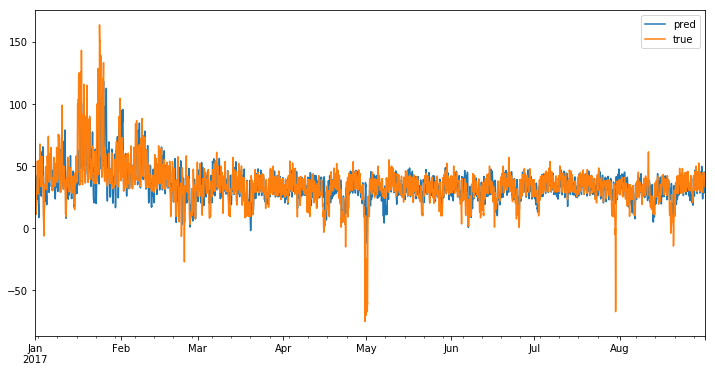

In [66]:
results.plot(figsize=(12, 6))

## Trying different architectures

In [51]:
archs = []

##### Smaller Convolutional layer

In [52]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(32, kernel_size=24, strides=24, padding='valid')(input_layer)
# x = LSTM(32, return_sequences=True, recurrent_activation='relu')(x)
x = LSTM(32, recurrent_activation='relu')(x)
output_layer = Dense(24)(x)
model_a = Model(inputs=[input_layer], outputs=[output_layer])
archs.append(model_a)

##### Smaller Recurrent layer

In [53]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(input_layer)
# x = LSTM(32, return_sequences=True, recurrent_activation='relu')(x)
x = LSTM(16, recurrent_activation='relu')(x)
output_layer = Dense(24)(x)
model_b = Model(inputs=[input_layer], outputs=[output_layer])
archs.append(model_b)

##### Smaller Convolutional and Recurrent layer

In [54]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(32, kernel_size=24, strides=24, padding='valid')(input_layer)
# x = LSTM(32, return_sequences=True, recurrent_activation='relu')(x)
x = LSTM(16, recurrent_activation='relu')(x)
output_layer = Dense(24)(x)
model_c = Model(inputs=[input_layer], outputs=[output_layer])
archs.append(model_c)

##### Bigger Convolutional layer

In [55]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(128, kernel_size=24, strides=24, padding='valid')(input_layer)
# x = LSTM(32, return_sequences=True, recurrent_activation='relu')(x)
x = LSTM(32, recurrent_activation='relu')(x)
output_layer = Dense(24)(x)
model_d = Model(inputs=[input_layer], outputs=[output_layer])
archs.append(model_d)

##### Bigger Recurrent layer

In [56]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(input_layer)
# x = LSTM(32, return_sequences=True, recurrent_activation='relu')(x)
x = LSTM(64, recurrent_activation='relu')(x)
output_layer = Dense(24)(x)
model_e = Model(inputs=[input_layer], outputs=[output_layer])
archs.append(model_e)

##### Bigger Convolutional and Recurrent Layer

In [57]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(128, kernel_size=24, strides=24, padding='valid')(input_layer)
# x = LSTM(32, return_sequences=True, recurrent_activation='relu')(x)
x = LSTM(64, recurrent_activation='relu')(x)
output_layer = Dense(24)(x)
model_f = Model(inputs=[input_layer], outputs=[output_layer])
archs.append(model_f)

##### With additional Dense Layer

In [58]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(input_layer)
# x = LSTM(32, return_sequences=True, recurrent_activation='relu')(x)
x = LSTM(32, recurrent_activation='relu')(x)
x = Dense(32)(x)
output_layer = Dense(24)(x)
model_g = Model(inputs=[input_layer], outputs=[output_layer])
archs.append(model_g)

In [59]:
for i, model in enumerate(archs):
    model.compile(loss='mse', optimizer='adam')
    checkpoint = ModelCheckpoint('./models/timeseries_architecture_testing_model_{}.hdf5'.format(i), save_best_only=True)
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[checkpoint], 
                     verbose=0, batch_size=50, epochs=200)
    best = load_model('./models/timeseries_architecture_testing_model_{}.hdf5'.format(i))
    pred = best.predict(features_test)
    pred = da_scaler.inverse_transform(pred.flatten().reshape(-1, 1))
    index = da_prep[da_prep.index.year == 2017].index
    results = pd.DataFrame({'pred':pred.flatten(), 'true':test_raw.DA_price}, index=index)
    print('MAE of model {}: '.format(i), mean_absolute_error(y_pred=pred, y_true=test_raw.DA_price.as_matrix()))

MAE of model 0:  5.762188079
MAE of model 1:  6.15960305753
MAE of model 2:  5.75341784547
MAE of model 3:  5.93660107021
MAE of model 4:  5.95871355456
MAE of model 5:  5.78408111743
MAE of model 6:  5.9574115549


#### Adding a linear bypass

In [67]:
conv_input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lin_input_layer = Input(shape=(X_train.shape[1],))

x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(conv_input_layer)
x = LSTM(32, recurrent_activation='relu')(x)
x = Dense(24)(x)

y = Dense(64)(lin_input_layer)
y = Dense(24)(y)

add = Add()([x, y])

model = Model(inputs=[conv_input_layer, lin_input_layer], outputs=[add])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_19 (InputLayer)            (None, 168, 1)        0                                            
____________________________________________________________________________________________________
conv1d_17 (Conv1D)               (None, 7, 64)         1600        input_19[0][0]                   
____________________________________________________________________________________________________
input_20 (InputLayer)            (None, 168)           0                                            
____________________________________________________________________________________________________
lstm_17 (LSTM)                   (None, 32)            12416       conv1d_17[0][0]                  
___________________________________________________________________________________________

In [34]:
model.compile(loss='mse', optimizer='adam')
checkpoint = ModelCheckpoint('./models/timeseries_linear_bypass.hdf5', save_best_only=True)
hist = model.fit([X_train, X_train.reshape(X_train.shape[0], X_train.shape[1])], y_train,
                 validation_data=([X_valid, X_valid.reshape(X_valid.shape[0], X_valid.shape[1])], y_valid),
                 callbacks=[checkpoint], 
                 verbose=1, batch_size=50, epochs=200)

best = load_model('./models/timeseries_linear_bypass.hdf5')
pred = best.predict([features_test, features_test.reshape(features_test.shape[0], features_test.shape[1])])
pred = da_scaler.inverse_transform(pred.flatten().reshape(-1, 1))
index = da_prep[da_prep.index.year == 2017].index
results = pd.DataFrame({'pred':pred.flatten(), 'true':test_raw.DA_price}, index=index)

Train on 2756 samples, validate on 690 samples
Epoch 1/200
2756/2756 [==============================] - 1s - loss: 0.0812 - val_loss: 0.0169
Epoch 2/200
2756/2756 [==============================] - 0s - loss: 0.0146 - val_loss: 0.0131
Epoch 3/200
2756/2756 [==============================] - 0s - loss: 0.0116 - val_loss: 0.0106
Epoch 4/200
2756/2756 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0092
Epoch 5/200
2756/2756 [==============================] - 0s - loss: 0.0086 - val_loss: 0.0083
Epoch 6/200
2756/2756 [==============================] - 0s - loss: 0.0077 - val_loss: 0.0075
Epoch 7/200
2756/2756 [==============================] - 0s - loss: 0.0071 - val_loss: 0.0070
Epoch 8/200
2756/2756 [==============================] - 0s - loss: 0.0067 - val_loss: 0.0067
Epoch 9/200
2756/2756 [==============================] - 0s - loss: 0.0064 - val_loss: 0.0064
Epoch 10/200
2756/2756 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0064
Epoch 11/200

2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0032
Epoch 172/200
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0033
Epoch 173/200
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0030
Epoch 174/200
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0036
Epoch 175/200
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0032
Epoch 176/200
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 177/200
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0031
Epoch 178/200
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0040
Epoch 179/200
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0030
Epoch 180/200
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0040
Epoch 181/200
2756/2756 [=============================

In [69]:
print('MAE : ', mean_absolute_error(y_pred=pred, y_true=test_raw.DA_price.as_matrix()))

MAE :  5.65448441763


## Finetuning the model

In [60]:
conv_input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lin_input_layer = Input(shape=(X_train.shape[1],))

x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(conv_input_layer)
x = Dropout(0.2)(x)
x = LSTM(32, recurrent_activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(24)(x)

y = Dense(64)(lin_input_layer)
y = Dropout(0.2)(y)
y = Dense(24)(y)

add = Add()([x, y])

model = Model(inputs=[conv_input_layer, lin_input_layer], outputs=[add])

In [61]:
model.compile(loss='mse', optimizer='adam')
checkpoint = ModelCheckpoint('./models/timeseries_linear_bypass_dropout.hdf5', save_best_only=True)
hist = model.fit([X_train, X_train.reshape(X_train.shape[0], X_train.shape[1])], y_train,
                 validation_data=([X_valid, X_valid.reshape(X_valid.shape[0], X_valid.shape[1])], y_valid),
                 callbacks=[checkpoint], 
                 verbose=0, batch_size=50, epochs=200)

best = load_model('./models/timeseries_linear_bypass_dropout.hdf5')
pred = best.predict([features_test, features_test.reshape(features_test.shape[0], features_test.shape[1])])
pred = da_scaler.inverse_transform(pred.flatten().reshape(-1, 1))

In [62]:
print(mean_absolute_error(y_pred=pred, y_true=test_raw.DA_price.as_matrix()))

5.48096243085


In [64]:
conv_input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lin_input_layer = Input(shape=(X_train.shape[1],))

x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(conv_input_layer)
x = Dropout(0.2)(x)
x = LSTM(32, recurrent_activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(24)(x)

y = Dense(64, kernel_regularizer=l1_l2())(lin_input_layer)
y = Dropout(0.2)(y)
y = Dense(24)(y)

add = Add()([x, y])

model = Model(inputs=[conv_input_layer, lin_input_layer], outputs=[add])

In [65]:
model.compile(loss='mse', optimizer='adam')
checkpoint = ModelCheckpoint('./models/timeseries_linear_bypass_dropout_l1-l2.hdf5', save_best_only=True)
hist = model.fit([X_train, X_train.reshape(X_train.shape[0], X_train.shape[1])], y_train,
                 validation_data=([X_valid, X_valid.reshape(X_valid.shape[0], X_valid.shape[1])], y_valid),
                 callbacks=[checkpoint], 
                 verbose=0, batch_size=50, epochs=200)

best = load_model('./models/timeseries_linear_bypass_dropout_l1-l2.hdf5')
pred = best.predict([features_test, features_test.reshape(features_test.shape[0], features_test.shape[1])])
pred = da_scaler.inverse_transform(pred.flatten().reshape(-1, 1))

In [66]:
print(mean_absolute_error(y_pred=pred, y_true=test_raw.DA_price.as_matrix()))

5.85336531807


In [43]:
conv_input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lin_input_layer = Input(shape=(X_train.shape[1],))

x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(conv_input_layer)
x = Dropout(0.2)(x)
x = LSTM(32, recurrent_activation='relu', kernel_regularizer=l1_l2())(x)
x = Dropout(0.2)(x)
x = Dense(24)(x)

y = Dense(64, kernel_regularizer=l1_l2())(lin_input_layer)
y = Dropout(0.2)(y)
y = Dense(24)(y)

add = Add()([x, y])

model = Model(inputs=[conv_input_layer, lin_input_layer], outputs=[add])

In [44]:
model.compile(loss='mse', optimizer='adam')
checkpoint = ModelCheckpoint('./models/timeseries_linear_bypass_dropout_l1-l2.hdf5', save_best_only=True)
hist = model.fit([X_train, X_train.reshape(X_train.shape[0], X_train.shape[1])], y_train,
                 validation_data=([X_valid, X_valid.reshape(X_valid.shape[0], X_valid.shape[1])], y_valid),
                 callbacks=[checkpoint], 
                 verbose=0, batch_size=50, epochs=200)

best = load_model('./models/timeseries_linear_bypass_dropout_l1-l2.hdf5')
pred = best.predict([features_test, features_test.reshape(features_test.shape[0], features_test.shape[1])])
pred = da_scaler.inverse_transform(pred.flatten().reshape(-1, 1))

In [45]:
print(mean_absolute_error(y_pred=pred, y_true=test_raw.DA_price.as_matrix()))

8.19790622125


In [46]:
conv_input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lin_input_layer = Input(shape=(X_train.shape[1],))

x = Conv1D(64, kernel_size=24, strides=24, padding='valid', kernel_regularizer=l1_l2())(conv_input_layer)
x = Dropout(0.2)(x)
x = LSTM(32, recurrent_activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(24)(x)

y = Dense(64, kernel_regularizer=l1_l2())(lin_input_layer)
y = Dropout(0.2)(y)
y = Dense(24)(y)

add = Add()([x, y])

model = Model(inputs=[conv_input_layer, lin_input_layer], outputs=[add])

In [47]:
model.compile(loss='mse', optimizer='adam')
checkpoint = ModelCheckpoint('./models/timeseries_linear_bypass_dropout_l1-l2.hdf5', save_best_only=True)
hist = model.fit([X_train, X_train.reshape(X_train.shape[0], X_train.shape[1])], y_train,
                 validation_data=([X_valid, X_valid.reshape(X_valid.shape[0], X_valid.shape[1])], y_valid),
                 callbacks=[checkpoint], 
                 verbose=0, batch_size=50, epochs=200)

best = load_model('./models/timeseries_linear_bypass_dropout_l1-l2.hdf5')
pred = best.predict([features_test, features_test.reshape(features_test.shape[0], features_test.shape[1])])
pred = da_scaler.inverse_transform(pred.flatten().reshape(-1, 1))

In [48]:
print(mean_absolute_error(y_pred=pred, y_true=test_raw.DA_price.as_matrix()))

8.17709985824


### Hyperparameter tuning

sklearn GridSearchCV does not work with multi-input models, as stated in https://github.com/fchollet/keras/issues/6451

In [25]:
from sklearn.model_selection import ShuffleSplit, ParameterGrid
from sklearn.metrics import mean_squared_error

In [26]:
grid = {'optimizer': ['adam'],
                  'loss': ['mse'],
                  'batch_size': [50],
                  'dropout': [0.1, 0.2],
                  'l1_l2': [0, 0.01, 0.02],
                  'conv_activation': ['linear', 'relu'],
                  'recurrent_activation': ['linear', 'relu']}

In [27]:
tot = len(ParameterGrid(grid))

In [28]:
tot

24

In [ ]:
parameter_grid = ParameterGrid(grid)

results = {}

for i, params in enumerate(parameter_grid):
    print('training {} out of {} parameter configurations'.format(i, tot))
    param_results = {}
    splits = ShuffleSplit(n_splits=10, test_size=0.2, random_state=7).split(features_train, labels_train)
    
    for n, (train_indices, valid_indices) in enumerate(splits):
        print('   split {} training'.format(n))
        X_train = features_train[train_indices]
        X_valid = features_train[valid_indices]
        y_train = labels_train[train_indices]
        y_valid = labels_train[valid_indices]
        
        conv_input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
        lin_input_layer = Input(shape=(X_train.shape[1],))

        x = Conv1D(64, kernel_size=24, strides=24, padding='valid', activation=params['conv_activation'])(conv_input_layer)
        x = Dropout(params['dropout'])(x)
        x = LSTM(32, recurrent_activation=params['recurrent_activation'])(x)
        x = Dropout(params['dropout'])(x)
        x = Dense(24)(x)

        y = Dense(64, kernel_regularizer=l1_l2(params['l1_l2']))(lin_input_layer)
        y = Dropout(params['dropout'])(y)
        y = Dense(24)(y)

        add = Add()([x, y])

        model = Model(inputs=[conv_input_layer, lin_input_layer], outputs=[add])
        model.compile(loss=params['loss'], optimizer=params['optimizer'])

        checkpoint = ModelCheckpoint('./models/timeseries_grid_search.hdf5', save_best_only=True)
        _ = model.fit([X_train, X_train.reshape(X_train.shape[0], X_train.shape[1])], y_train,
                 validation_data=([X_valid, X_valid.reshape(X_valid.shape[0], X_valid.shape[1])], y_valid),
                 callbacks=[checkpoint], 
                 verbose=1, batch_size=params['batch_size'], epochs=150)

        best = load_model('./models/timeseries_grid_search.hdf5')
        pred = best.predict([features_test, features_test.reshape(features_test.shape[0], features_test.shape[1])])
        pred = da_scaler.inverse_transform(pred.flatten().reshape(-1, 1))

        mse = mean_squared_error(y_pred=pred, y_true=test_raw.DA_price.as_matrix())
        mae = mean_absolute_error(y_pred=pred, y_true=test_raw.DA_price.as_matrix())

        param_results['split{}'.format(n)] = {'mae':mae, 'mse':mse}
        
        print('done')

    mae_avg = np.mean([param_results[key]['mae'] for key in param_results.keys()])
    mse_avg = np.mean([param_results[key]['mse'] for key in param_results.keys()])

    results[str(params)] = {'splits':param_results, 'mae_avg':mae_avg, 'mse_avg':mse_avg}
    
    with open('./timeseries_gridsearch_results.json', 'w') as fp:
        json.dump(results, fp)

training 0 out of 24 parameter configurations
   split 0 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 4s - loss: 0.9211 - val_loss: 0.6983
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 0.5754 - val_loss: 0.4392
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 0.3516 - val_loss: 0.2604
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.2068 - val_loss: 0.1506
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.1191 - val_loss: 0.0857
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.0685 - val_loss: 0.0485
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0401 - val_loss: 0.0281
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0242 - val_loss: 0.0170
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0116
Epoch 10/150
2756/2756 [=================

2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0037
Epoch 87/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0034
Epoch 88/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0044
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0036
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0035
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0036
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0036
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0032
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0034
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0036
Epoch 96/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0059
Epoch 22/150
2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0102
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0069 - val_loss: 0.0064
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0048
Epoch 25/150
2756/2756 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0046
Epoch 26/150
2756/2756 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0086
Epoch 27/150
2756/2756 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0054
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0053
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0051
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0061
Epoch 31/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0034
Epoch 108/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0035
Epoch 109/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0037
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0036
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0035
Epoch 112/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0034
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0032
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0032
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0035
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0035
Epoch 117/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0042
Epoch 43/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0037
Epoch 44/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0038
Epoch 45/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0043
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0048
Epoch 47/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0059
Epoch 48/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0040
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0042
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0036
Epoch 51/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0034
Epoch 52/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0031
Epoch 129/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0029
Epoch 130/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0028
Epoch 131/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0034
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0032
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0029
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0029
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0029
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0029
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0032
Epoch 138/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0038
Epoch 64/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0039
Epoch 65/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0038
Epoch 66/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0039
Epoch 67/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0048
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0041
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0056
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0038
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0040
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0050
Epoch 73/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0028 - val_loss: 0.0030
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0028 - val_loss: 0.0029
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0028 - val_loss: 0.0030
done
   split 4 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 1s - loss: 0.9625 - val_loss: 0.7518
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 0.6473 - val_loss: 0.5245
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 0.4395 - val_loss: 0.3478
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.2882 - val_loss: 0.2250
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.1854 - val_loss: 0.1432
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.1187 - val_loss: 0.0908
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0758 - val_loss: 0.0

2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0041
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0046
Epoch 85/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0037
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0037
Epoch 87/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0043
Epoch 88/150
2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0043
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0039
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0040
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0045
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0036
Epoch 93/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0068 - val_loss: 0.0045
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0066 - val_loss: 0.0071
Epoch 20/150
2756/2756 [==============================] - 0s - loss: 0.0062 - val_loss: 0.0047
Epoch 21/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0041
Epoch 22/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0041
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0048
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0057
Epoch 25/150
2756/2756 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0050
Epoch 26/150
2756/2756 [==============================] - 0s - loss: 0.0062 - val_loss: 0.0040
Epoch 27/150
2756/2756 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0042
Epoch 28/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0031
Epoch 105/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0031
Epoch 106/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0031
Epoch 107/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0031
Epoch 108/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0035
Epoch 109/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0037
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0031
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0029
Epoch 112/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0031
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0030
Epoch 114/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0043
Epoch 40/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0054
Epoch 41/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0042
Epoch 42/150
2756/2756 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0064
Epoch 43/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0043
Epoch 44/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0045
Epoch 45/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0041
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0042
Epoch 47/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0045
Epoch 48/150
2756/2756 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0046
Epoch 49/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0033
Epoch 126/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0033
Epoch 127/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0037
Epoch 128/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0033
Epoch 129/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0032
Epoch 130/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0033
Epoch 131/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0033
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0034
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0035
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0035
Epoch 135/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0047
Epoch 61/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0040
Epoch 62/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0041
Epoch 63/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0044
Epoch 64/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0050
Epoch 65/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0051
Epoch 66/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0040
Epoch 67/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0039
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0040
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0041
Epoch 70/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0030
Epoch 146/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0029
Epoch 147/150
2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0030
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0029
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0029
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0030
done
   split 8 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 3s - loss: 0.8599 - val_loss: 0.6374
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 0.5030 - val_loss: 0.3657
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 0.2821 - val_loss: 0.1989
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.1530 - val_los

2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0035
Epoch 81/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0068
Epoch 82/150
2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0035
Epoch 83/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0035
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0043
Epoch 85/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0036
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0036
Epoch 87/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0037
Epoch 88/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0034
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0036
Epoch 90/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0078 - val_loss: 0.0057
Epoch 16/150
2756/2756 [==============================] - 0s - loss: 0.0073 - val_loss: 0.0113
Epoch 17/150
2756/2756 [==============================] - 0s - loss: 0.0076 - val_loss: 0.0052
Epoch 18/150
2756/2756 [==============================] - 0s - loss: 0.0070 - val_loss: 0.0051
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0064 - val_loss: 0.0048
Epoch 20/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0047
Epoch 21/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0073
Epoch 22/150
2756/2756 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0059
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0065
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0046
Epoch 25/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0033
Epoch 102/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0037
Epoch 103/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0031
Epoch 104/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0032
Epoch 105/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0030
Epoch 106/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0035
Epoch 107/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0035
Epoch 108/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0035
Epoch 109/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0032
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0031
Epoch 111/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0044
Epoch 36/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0047
Epoch 37/150
2756/2756 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0047
Epoch 38/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0048
Epoch 39/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0080
Epoch 40/150
2756/2756 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0042
Epoch 41/150
2756/2756 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0042
Epoch 42/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0043
Epoch 43/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0040
Epoch 44/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0051
Epoch 45/150
2756/2756 [==============================] - ETA: 

2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0032
Epoch 121/150
2756/2756 [==============================] - ETA: 0s - loss: 0.003 - 0s - loss: 0.0033 - val_loss: 0.0032
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0031
Epoch 123/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0037
Epoch 124/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0032
Epoch 125/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0032
Epoch 126/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0041
Epoch 127/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0031
Epoch 128/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0034
Epoch 129/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0032
Epoch 130/150
2756/2756 [=====

2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0045
Epoch 55/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0047
Epoch 56/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0048
Epoch 57/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0044
Epoch 58/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0040
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0054
Epoch 60/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0041
Epoch 61/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0063
Epoch 62/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0050
Epoch 63/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0054
Epoch 64/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0031
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0032
Epoch 141/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 142/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0037
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0033
Epoch 145/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0030
Epoch 146/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0030
Epoch 147/150
2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0031
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0031
Epoch 149/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0058
Epoch 74/150
2756/2756 [==============================] - ETA: 0s - loss: 0.004 - 0s - loss: 0.0046 - val_loss: 0.0037
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0040
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0035
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0038
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0037
Epoch 79/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0039
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0039
Epoch 81/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0046
Epoch 82/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0035
Epoch 83/150
2756/2756 [===============

2756/2756 [==============================] - 0s - loss: 0.0750 - val_loss: 0.0538
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0452 - val_loss: 0.0320
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0197
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0188 - val_loss: 0.0134
Epoch 10/150
2756/2756 [==============================] - 0s - loss: 0.0131 - val_loss: 0.0095
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.0101 - val_loss: 0.0069
Epoch 12/150
2756/2756 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0059
Epoch 13/150
2756/2756 [==============================] - 0s - loss: 0.0074 - val_loss: 0.0056
Epoch 14/150
2756/2756 [==============================] - 0s - loss: 0.0068 - val_loss: 0.0050
Epoch 15/150
2756/2756 [==============================] - 0s - loss: 0.0064 - val_loss: 0.0047
Epoch 16/150
2756/2756 [==============================] - 0s - los

2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0041
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0038
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0038
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0037
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0036
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0036
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 98/150
2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0038
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0035
Epoch 100/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0037
Epoch 101/150
2756/2756 [==============================] - ETA

2756/2756 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0058
Epoch 26/150
2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0052
Epoch 27/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0057
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0053
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0068
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0044
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0060
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0047
Epoch 33/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0045
Epoch 34/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0093
Epoch 35/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0035
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0033
Epoch 112/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0033
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0035
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0032
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0033
Epoch 116/150
2756/2756 [==============================] - ETA: 0s - loss: 0.003 - 0s - loss: 0.0032 - val_loss: 0.0037
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0035
Epoch 118/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0032
Epoch 119/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0039
Epoch 120/150
2756/2756 [=====

2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0041
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0036
Epoch 47/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0039
Epoch 48/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0035
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0037
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0036
Epoch 51/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0039
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0046
Epoch 53/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0034
Epoch 54/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0044
Epoch 55/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0028
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0028
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0028
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0031
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0026
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0028
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0027
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0027
Epoch 139/150
2756/2756 [==============================] - 0s - loss: 0.0028 - val_loss: 0.0027
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0031
Epoch 141/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0056
Epoch 67/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0046
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0051
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0043
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0061
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0040
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0038
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0043
Epoch 74/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0040
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0042
Epoch 76/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 5s - loss: 0.9555 - val_loss: 0.7452
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 0.6398 - val_loss: 0.5132
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 0.4260 - val_loss: 0.3304
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.2699 - val_loss: 0.2048
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.1659 - val_loss: 0.1237
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.1005 - val_loss: 0.0740
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0610 - val_loss: 0.0451
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0377 - val_loss: 0.0277
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0241 - val_loss: 0.0172
Epoch 10/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0119
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.

2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0043
Epoch 88/150
2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0052
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0045
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0041
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0036
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0038
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0041
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0036
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0036
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0037
Epoch 97/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0046
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0055
Epoch 25/150
2756/2756 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0054
Epoch 26/150
2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0047
Epoch 27/150
2756/2756 [==============================] - 0s - loss: 0.0065 - val_loss: 0.0046
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0052
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0086
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0046
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0052
Epoch 32/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0038
Epoch 109/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0034
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0039
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0035
Epoch 112/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0033
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0032
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0033
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0035
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0048
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0035
Epoch 118/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0044
Epoch 44/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0039
Epoch 45/150
2756/2756 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0038
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0047
Epoch 47/150
2756/2756 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0039
Epoch 48/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0040
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0038
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0041
Epoch 51/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0042
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0038
Epoch 53/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0031
Epoch 130/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0031
Epoch 131/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0029
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0028
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0030
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0029
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0028
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0029
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0028
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0028
Epoch 139/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0168
Epoch 64/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0164
Epoch 65/150
2756/2756 [==============================] - ETA: 0s - loss: 0.016 - 0s - loss: 0.0168 - val_loss: 0.0163
Epoch 66/150
2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0164
Epoch 67/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0165
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0175
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0158
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0171
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0164
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0158
Epoch 73/150
2756/2756 [===============

2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0152
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0153 - val_loss: 0.0151
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0151 - val_loss: 0.0154
done
   split 1 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 7s - loss: 7.6463 - val_loss: 5.1666
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 3.4106 - val_loss: 1.8368
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 0.9654 - val_loss: 0.3207
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.1397 - val_loss: 0.0414
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.0294 - val_loss: 0.0197
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.0219 - val_loss: 0.0182
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0204 - val_loss: 0.0

2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0169
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0164
Epoch 85/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0163
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0161
Epoch 87/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0159
Epoch 88/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0159
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0164
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0158
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0158
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0163
Epoch 93/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0190 - val_loss: 0.0170
Epoch 18/150
2756/2756 [==============================] - 0s - loss: 0.0186 - val_loss: 0.0168
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0185 - val_loss: 0.0170
Epoch 20/150
2756/2756 [==============================] - 0s - loss: 0.0186 - val_loss: 0.0170
Epoch 21/150
2756/2756 [==============================] - 0s - loss: 0.0186 - val_loss: 0.0176
Epoch 22/150
2756/2756 [==============================] - 0s - loss: 0.0188 - val_loss: 0.0169
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0167
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0196
Epoch 25/150
2756/2756 [==============================] - 0s - loss: 0.0186 - val_loss: 0.0168
Epoch 26/150
2756/2756 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0178
Epoch 27/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0154
Epoch 103/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0158
Epoch 104/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0160
Epoch 105/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0159
Epoch 106/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0163
Epoch 107/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0152
Epoch 108/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0155
Epoch 109/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0155
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0152
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0150
Epoch 112/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0178
Epoch 38/150
2756/2756 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0167
Epoch 39/150
2756/2756 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0167
Epoch 40/150
2756/2756 [==============================] - 0s - loss: 0.0177 - val_loss: 0.0170
Epoch 41/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0168
Epoch 42/150
2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0170
Epoch 43/150
2756/2756 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0171
Epoch 44/150
2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0174
Epoch 45/150
2756/2756 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0165
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0163
Epoch 47/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0153
Epoch 123/150
2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0154
Epoch 124/150
2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0154
Epoch 125/150
2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0156
Epoch 126/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0156
Epoch 127/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0158
Epoch 128/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0160
Epoch 129/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0153
Epoch 130/150
2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0155
Epoch 131/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0166
Epoch 132/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0166
Epoch 58/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0163
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0164
Epoch 60/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0165
Epoch 61/150
2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0174
Epoch 62/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0162
Epoch 63/150
2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0172
Epoch 64/150
2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0165
Epoch 65/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0160
Epoch 66/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0163
Epoch 67/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0151 - val_loss: 0.0156
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0152 - val_loss: 0.0157
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0158
Epoch 145/150
2756/2756 [==============================] - 0s - loss: 0.0153 - val_loss: 0.0153
Epoch 146/150
2756/2756 [==============================] - 0s - loss: 0.0153 - val_loss: 0.0159
Epoch 147/150
2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0154
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0153 - val_loss: 0.0154
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0151 - val_loss: 0.0156
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0151 - val_loss: 0.0153
done
   split 5 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 8s - loss: 7.5333 - v

2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0167
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0160
Epoch 79/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0165
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0166
Epoch 81/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0155
Epoch 82/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0154
Epoch 83/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0159
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0160
Epoch 85/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0155
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0154
Epoch 87/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0192 - val_loss: 0.0181
Epoch 13/150
2756/2756 [==============================] - 0s - loss: 0.0191 - val_loss: 0.0179
Epoch 14/150
2756/2756 [==============================] - 0s - loss: 0.0195 - val_loss: 0.0227
Epoch 15/150
2756/2756 [==============================] - 0s - loss: 0.0205 - val_loss: 0.0184
Epoch 16/150
2756/2756 [==============================] - 0s - loss: 0.0190 - val_loss: 0.0175
Epoch 17/150
2756/2756 [==============================] - 0s - loss: 0.0190 - val_loss: 0.0180
Epoch 18/150
2756/2756 [==============================] - 0s - loss: 0.0189 - val_loss: 0.0185
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0191 - val_loss: 0.0176
Epoch 20/150
2756/2756 [==============================] - 0s - loss: 0.0186 - val_loss: 0.0173
Epoch 21/150
2756/2756 [==============================] - 0s - loss: 0.0185 - val_loss: 0.0178
Epoch 22/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0163
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0159
Epoch 100/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0163
Epoch 101/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0160
Epoch 102/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0163
Epoch 103/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0159
Epoch 104/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0158
Epoch 105/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0161
Epoch 106/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0162
Epoch 107/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0162
Epoch 108/150
2756/2756 [==============================

2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0173
Epoch 34/150
2756/2756 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0174
Epoch 35/150
2756/2756 [==============================] - 0s - loss: 0.0177 - val_loss: 0.0172
Epoch 36/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0166
Epoch 37/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0172
Epoch 38/150
2756/2756 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0170
Epoch 39/150
2756/2756 [==============================] - 0s - loss: 0.0177 - val_loss: 0.0170
Epoch 40/150
2756/2756 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0170
Epoch 41/150
2756/2756 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0167
Epoch 42/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0172
Epoch 43/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0160
Epoch 120/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0160
Epoch 121/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0160
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0161
Epoch 123/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0159
Epoch 124/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0156
Epoch 125/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0156
Epoch 126/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0154
Epoch 127/150
2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0151
Epoch 128/150
2756/2756 [==============================] - 0s - loss: 0.0153 - val_loss: 0.0154
Epoch 129/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0162
Epoch 55/150
2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0166
Epoch 56/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0173
Epoch 57/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0163
Epoch 58/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0158
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0160
Epoch 60/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0168
Epoch 61/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0158
Epoch 62/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0159
Epoch 63/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0163
Epoch 64/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0153 - val_loss: 0.0157
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0153 - val_loss: 0.0155
Epoch 141/150
2756/2756 [==============================] - 0s - loss: 0.0152 - val_loss: 0.0152
Epoch 142/150
2756/2756 [==============================] - 0s - loss: 0.0152 - val_loss: 0.0164
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0153
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0152 - val_loss: 0.0155
Epoch 145/150
2756/2756 [==============================] - 0s - loss: 0.0152 - val_loss: 0.0158
Epoch 146/150
2756/2756 [==============================] - 0s - loss: 0.0151 - val_loss: 0.0155
Epoch 147/150
2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0157
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0160
Epoch 149/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0159
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0160
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0160
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0157
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0155
Epoch 79/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0157
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0160
Epoch 81/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0162
Epoch 82/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0158
Epoch 83/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0162
Epoch 84/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0207 - val_loss: 0.0185
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0204 - val_loss: 0.0183
Epoch 10/150
2756/2756 [==============================] - 0s - loss: 0.0199 - val_loss: 0.0181
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.0198 - val_loss: 0.0180
Epoch 12/150
2756/2756 [==============================] - 0s - loss: 0.0193 - val_loss: 0.0176
Epoch 13/150
2756/2756 [==============================] - 0s - loss: 0.0197 - val_loss: 0.0205
Epoch 14/150
2756/2756 [==============================] - 0s - loss: 0.0198 - val_loss: 0.0195
Epoch 15/150
2756/2756 [==============================] - 0s - loss: 0.0193 - val_loss: 0.0179
Epoch 16/150
2756/2756 [==============================] - 0s - loss: 0.0192 - val_loss: 0.0183
Epoch 17/150
2756/2756 [==============================] - 0s - loss: 0.0189 - val_loss: 0.0185
Epoch 18/150
2756/2756 [==============================] - 0s - l

2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0164
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0155
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0156
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0157
Epoch 98/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0157
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0156
Epoch 100/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0155
Epoch 101/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0158
Epoch 102/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0155
Epoch 103/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0157
Epoch 104/150
2756/2756 [==============================] - 

2756/2756 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0181
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0173
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0174 - val_loss: 0.0171
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0176
Epoch 33/150
2756/2756 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0173
Epoch 34/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0170
Epoch 35/150
2756/2756 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0165
Epoch 36/150
2756/2756 [==============================] - 0s - loss: 0.0174 - val_loss: 0.0168
Epoch 37/150
2756/2756 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0168
Epoch 38/150
2756/2756 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0169
Epoch 39/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0162
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0169
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0156
Epoch 118/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0158
Epoch 119/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0158
Epoch 120/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0161
Epoch 121/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0159
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0155
Epoch 123/150
2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0155
Epoch 124/150
2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0153
Epoch 125/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0175
Epoch 51/150
2756/2756 [==============================] - 0s - loss: 0.0177 - val_loss: 0.0174
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0167
Epoch 53/150
2756/2756 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0165
Epoch 54/150
2756/2756 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0165
Epoch 55/150
2756/2756 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0167
Epoch 56/150
2756/2756 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0169
Epoch 57/150
2756/2756 [==============================] - 0s - loss: 0.0174 - val_loss: 0.0165
Epoch 58/150
2756/2756 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0158
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0174 - val_loss: 0.0168
Epoch 60/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0157
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0153
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0152 - val_loss: 0.0155
Epoch 139/150
2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0156
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0153 - val_loss: 0.0154
Epoch 141/150
2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0152
Epoch 142/150
2756/2756 [==============================] - 0s - loss: 0.0152 - val_loss: 0.0156
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0157
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0155
Epoch 145/150
2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0153
Epoch 146/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0158
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0160
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0165
Epoch 74/150
2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0159
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0155
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0156
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0171
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0158
Epoch 79/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0156
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0158
Epoch 81/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0218 - val_loss: 0.0192
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0210 - val_loss: 0.0187
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0210 - val_loss: 0.0187
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0205 - val_loss: 0.0191
Epoch 10/150
2756/2756 [==============================] - 0s - loss: 0.0201 - val_loss: 0.0231
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.0206 - val_loss: 0.0187
Epoch 12/150
2756/2756 [==============================] - 0s - loss: 0.0199 - val_loss: 0.0191
Epoch 13/150
2756/2756 [==============================] - 0s - loss: 0.0198 - val_loss: 0.0183
Epoch 14/150
2756/2756 [==============================] - 0s - loss: 0.0193 - val_loss: 0.0186
Epoch 15/150
2756/2756 [==============================] - 0s - loss: 0.0194 - val_loss: 0.0189
Epoch 16/150
2756/2756 [==============================] - 0s - los

2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0171
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0156
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0159
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0159
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0156
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0158
Epoch 98/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0169
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0157
Epoch 100/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0155
Epoch 101/150
2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0162
Epoch 102/150
2756/2756 [==============================] - 0s

2756/2756 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0166
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0180
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0166
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0173
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0163
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0165
Epoch 33/150
2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0167
Epoch 34/150
2756/2756 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0206
Epoch 35/150
2756/2756 [==============================] - 0s - loss: 0.0189 - val_loss: 0.0172
Epoch 36/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0167
Epoch 37/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0155
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0155
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0151
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0152
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0155
Epoch 118/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0154
Epoch 119/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0151
Epoch 120/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0152
Epoch 121/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0153
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0152
Epoch 123/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0160
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0166
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0165
Epoch 51/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0164
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0166
Epoch 53/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0160
Epoch 54/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0165
Epoch 55/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0171
Epoch 56/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0176
Epoch 57/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0167
Epoch 58/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0152 - val_loss: 0.0158
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0151 - val_loss: 0.0154
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0151 - val_loss: 0.0156
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0151 - val_loss: 0.0156
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0152 - val_loss: 0.0156
Epoch 139/150
2756/2756 [==============================] - 0s - loss: 0.0152 - val_loss: 0.0162
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0158
Epoch 141/150
2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0160
Epoch 142/150
2756/2756 [==============================] - 0s - loss: 0.0154 - val_loss: 0.0156
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0156
Epoch 144/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0168
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0161
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0159
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0160
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0174
Epoch 74/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0161
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0160
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0160
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0158
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0157
Epoch 79/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0565 - val_loss: 0.0209
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.0222 - val_loss: 0.0197
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.0210 - val_loss: 0.0216
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0208 - val_loss: 0.0191
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0202 - val_loss: 0.0195
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0202 - val_loss: 0.0190
Epoch 10/150
2756/2756 [==============================] - 0s - loss: 0.0202 - val_loss: 0.0182
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.0197 - val_loss: 0.0189
Epoch 12/150
2756/2756 [==============================] - 0s - loss: 0.0197 - val_loss: 0.0194
Epoch 13/150
2756/2756 [==============================] - 0s - loss: 0.0200 - val_loss: 0.0183
Epoch 14/150
2756/2756 [==============================] - 0s - loss:

2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0159
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0157
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0157
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0160
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0160
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0162
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0159
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0164
Epoch 98/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0156
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0156
Epoch 100/150
2756/2756 [==============================] - 0s -

2756/2756 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0201
Epoch 26/150
2756/2756 [==============================] - 0s - loss: 0.0193 - val_loss: 0.0191
Epoch 27/150
2756/2756 [==============================] - 0s - loss: 0.0190 - val_loss: 0.0176
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0175
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0172
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0167
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0197
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0188 - val_loss: 0.0167
Epoch 33/150
2756/2756 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0177
Epoch 34/150
2756/2756 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0169
Epoch 35/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0156
Epoch 112/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0161
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0158
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0154
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0152
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0158
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0152
Epoch 118/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0155
Epoch 119/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0155
Epoch 120/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0152
Epoch 121/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0283 - val_loss: 0.0282
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0274
Epoch 47/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0276
Epoch 48/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0274
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0274
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0273
Epoch 51/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0276
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0276
Epoch 53/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0281
Epoch 54/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0276
Epoch 55/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0266
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0267
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0276
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0266
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0267 - val_loss: 0.0266
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0271
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0276
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0268
Epoch 139/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0270
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0271
Epoch 141/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0277
Epoch 67/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0285
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0277
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0279
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0283
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0280
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0279
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0276
Epoch 74/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0280
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0276
Epoch 76/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 13s - loss: 13.3868 - val_loss: 8.4119
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 5.1202 - val_loss: 2.3068
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 0.9520 - val_loss: 0.1350
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.0603 - val_loss: 0.0327
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.0350 - val_loss: 0.0309
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.0340 - val_loss: 0.0307
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0331 - val_loss: 0.0320
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0330 - val_loss: 0.0297
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0323 - val_loss: 0.0305
Epoch 10/150
2756/2756 [==============================] - 0s - loss: 0.0318 - val_loss: 0.0293
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 

2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0273
Epoch 88/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0273
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0279
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0282
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0276
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0275
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0268
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0267
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0281
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0269
Epoch 97/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0301 - val_loss: 0.0284
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0300 - val_loss: 0.0292
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0300 - val_loss: 0.0293
Epoch 25/150
2756/2756 [==============================] - 0s - loss: 0.0301 - val_loss: 0.0289
Epoch 26/150
2756/2756 [==============================] - 0s - loss: 0.0302 - val_loss: 0.0298
Epoch 27/150
2756/2756 [==============================] - 0s - loss: 0.0299 - val_loss: 0.0290
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0299
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0303 - val_loss: 0.0287
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0295 - val_loss: 0.0286
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0297 - val_loss: 0.0279
Epoch 32/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0275
Epoch 109/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0271
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0274
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0269
Epoch 112/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0272
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0270
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0263
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0269
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0265 - val_loss: 0.0267
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0265 - val_loss: 0.0265
Epoch 118/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0283 - val_loss: 0.0282
Epoch 44/150
2756/2756 [==============================] - 0s - loss: 0.0290 - val_loss: 0.0301
Epoch 45/150
2756/2756 [==============================] - 0s - loss: 0.0293 - val_loss: 0.0281
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0297
Epoch 47/150
2756/2756 [==============================] - 0s - loss: 0.0289 - val_loss: 0.0299
Epoch 48/150
2756/2756 [==============================] - 0s - loss: 0.0292 - val_loss: 0.0283
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0282
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0277
Epoch 51/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0283
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0286
Epoch 53/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0270
Epoch 130/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0283
Epoch 131/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0278
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0270
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0272
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0272
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0271
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0267
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0266
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0272
Epoch 139/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0272
Epoch 65/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0273
Epoch 66/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0273
Epoch 67/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0273
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0267
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0274
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0277
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0270
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0273
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0276
Epoch 74/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0264
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0267 - val_loss: 0.0263
done
   split 6 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 15s - loss: 13.3064 - val_loss: 8.2418
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 4.9445 - val_loss: 2.1512
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 0.8622 - val_loss: 0.1193
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.0569 - val_loss: 0.0329
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.0352 - val_loss: 0.0318
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.0335 - val_loss: 0.0310
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0330 - val_loss: 0.0322
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0324 - val_loss: 0.0

2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0277
Epoch 85/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0278
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0270
Epoch 87/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0275
Epoch 88/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0273
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0270
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0278
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0268
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0269
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0270
Epoch 94/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0307 - val_loss: 0.0296
Epoch 20/150
2756/2756 [==============================] - 0s - loss: 0.0310 - val_loss: 0.0327
Epoch 21/150
2756/2756 [==============================] - 0s - loss: 0.0308 - val_loss: 0.0294
Epoch 22/150
2756/2756 [==============================] - 0s - loss: 0.0301 - val_loss: 0.0294
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0308 - val_loss: 0.0303
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0302 - val_loss: 0.0292
Epoch 25/150
2756/2756 [==============================] - 0s - loss: 0.0302 - val_loss: 0.0296
Epoch 26/150
2756/2756 [==============================] - 0s - loss: 0.0299 - val_loss: 0.0289
Epoch 27/150
2756/2756 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0291
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0297 - val_loss: 0.0291
Epoch 29/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0275
Epoch 106/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0271
Epoch 107/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0270
Epoch 108/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0271
Epoch 109/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0273
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0273
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0269
Epoch 112/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0272
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0275
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0269
Epoch 115/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0286 - val_loss: 0.0305
Epoch 41/150
2756/2756 [==============================] - 0s - loss: 0.0293 - val_loss: 0.0283
Epoch 42/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0285
Epoch 43/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0288
Epoch 44/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0281
Epoch 45/150
2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0283
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0290 - val_loss: 0.0292
Epoch 47/150
2756/2756 [==============================] - 0s - loss: 0.0287 - val_loss: 0.0275
Epoch 48/150
2756/2756 [==============================] - 0s - loss: 0.0290 - val_loss: 0.0289
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0289 - val_loss: 0.0284
Epoch 50/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0268
Epoch 127/150
2756/2756 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0273
Epoch 128/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0280
Epoch 129/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0271
Epoch 130/150
2756/2756 [==============================] - 0s - loss: 0.0267 - val_loss: 0.0267
Epoch 131/150
2756/2756 [==============================] - 0s - loss: 0.0267 - val_loss: 0.0273
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0271
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0272
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0268
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0267 - val_loss: 0.0271
Epoch 136/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0280
Epoch 62/150
2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0279
Epoch 63/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0276
Epoch 64/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0274
Epoch 65/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0273
Epoch 66/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0274
Epoch 67/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0268
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0288
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0286 - val_loss: 0.0272
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0271
Epoch 71/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0263 - val_loss: 0.0267
Epoch 147/150
2756/2756 [==============================] - 0s - loss: 0.0263 - val_loss: 0.0267
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0265
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0265 - val_loss: 0.0264
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0263 - val_loss: 0.0269
done
training 5 out of 24 parameter configurations
   split 0 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 16s - loss: 13.6469 - val_loss: 8.6730
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 5.3487 - val_loss: 2.4610
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 1.0602 - val_loss: 0.1906
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.0773 - val_loss: 0.0343
Epoch 5/150
2756/2756 [===============

2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0269
Epoch 82/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0273
Epoch 83/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0276
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0269
Epoch 85/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0275
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0278
Epoch 87/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0265
Epoch 88/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0268
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0278
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0269
Epoch 91/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0308 - val_loss: 0.0297
Epoch 17/150
2756/2756 [==============================] - 0s - loss: 0.0309 - val_loss: 0.0297
Epoch 18/150
2756/2756 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0290
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0308 - val_loss: 0.0303
Epoch 20/150
2756/2756 [==============================] - 0s - loss: 0.0301 - val_loss: 0.0304
Epoch 21/150
2756/2756 [==============================] - 0s - loss: 0.0308 - val_loss: 0.0294
Epoch 22/150
2756/2756 [==============================] - 0s - loss: 0.0304 - val_loss: 0.0293
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0301 - val_loss: 0.0293
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0300 - val_loss: 0.0288
Epoch 25/150
2756/2756 [==============================] - 0s - loss: 0.0301 - val_loss: 0.0299
Epoch 26/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0275
Epoch 103/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0278
Epoch 104/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0271
Epoch 105/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0270
Epoch 106/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0267
Epoch 107/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0271
Epoch 108/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0271
Epoch 109/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0275
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0272
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0271
Epoch 112/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0300 - val_loss: 0.0283
Epoch 38/150
2756/2756 [==============================] - 0s - loss: 0.0290 - val_loss: 0.0277
Epoch 39/150
2756/2756 [==============================] - 0s - loss: 0.0293 - val_loss: 0.0276
Epoch 40/150
2756/2756 [==============================] - 0s - loss: 0.0288 - val_loss: 0.0281
Epoch 41/150
2756/2756 [==============================] - 0s - loss: 0.0292 - val_loss: 0.0283
Epoch 42/150
2756/2756 [==============================] - 0s - loss: 0.0290 - val_loss: 0.0279
Epoch 43/150
2756/2756 [==============================] - 0s - loss: 0.0288 - val_loss: 0.0276
Epoch 44/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0279
Epoch 45/150
2756/2756 [==============================] - 0s - loss: 0.0286 - val_loss: 0.0277
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0287 - val_loss: 0.0281
Epoch 47/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0266
Epoch 124/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0261
Epoch 125/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0268
Epoch 126/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0272
Epoch 127/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0266
Epoch 128/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0273
Epoch 129/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0271
Epoch 130/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0260
Epoch 131/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0262
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0274
Epoch 133/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0278
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0281
Epoch 60/150
2756/2756 [==============================] - 0s - loss: 0.0283 - val_loss: 0.0281
Epoch 61/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0279
Epoch 62/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0272
Epoch 63/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0272
Epoch 64/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0273
Epoch 65/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0269
Epoch 66/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0277
Epoch 67/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0276
Epoch 68/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0269
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0270
Epoch 145/150
2756/2756 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0267
Epoch 146/150
2756/2756 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0263
Epoch 147/150
2756/2756 [==============================] - 0s - loss: 0.0260 - val_loss: 0.0261
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0265 - val_loss: 0.0267
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0267 - val_loss: 0.0264
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0264 - val_loss: 0.0267
done
   split 4 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 17s - loss: 13.7689 - val_loss: 8.7420
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 5.3850 - v

2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0273
Epoch 79/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0277
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0272
Epoch 81/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0269
Epoch 82/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0282
Epoch 83/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0296
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0276
Epoch 85/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0274
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0273
Epoch 87/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0274
Epoch 88/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0324 - val_loss: 0.0296
Epoch 14/150
2756/2756 [==============================] - 0s - loss: 0.0314 - val_loss: 0.0293
Epoch 15/150
2756/2756 [==============================] - 0s - loss: 0.0313 - val_loss: 0.0294
Epoch 16/150
2756/2756 [==============================] - 0s - loss: 0.0310 - val_loss: 0.0294
Epoch 17/150
2756/2756 [==============================] - 0s - loss: 0.0315 - val_loss: 0.0305
Epoch 18/150
2756/2756 [==============================] - 0s - loss: 0.0313 - val_loss: 0.0287
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0309 - val_loss: 0.0288
Epoch 20/150
2756/2756 [==============================] - 0s - loss: 0.0309 - val_loss: 0.0300
Epoch 21/150
2756/2756 [==============================] - 0s - loss: 0.0303 - val_loss: 0.0286
Epoch 22/150
2756/2756 [==============================] - 0s - loss: 0.0303 - val_loss: 0.0286
Epoch 23/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0272
Epoch 100/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0269
Epoch 101/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0268
Epoch 102/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0269
Epoch 103/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0266
Epoch 104/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0260
Epoch 105/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0262
Epoch 106/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0263
Epoch 107/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0263
Epoch 108/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0269
Epoch 109/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0292 - val_loss: 0.0287
Epoch 35/150
2756/2756 [==============================] - 0s - loss: 0.0290 - val_loss: 0.0285
Epoch 36/150
2756/2756 [==============================] - 0s - loss: 0.0289 - val_loss: 0.0294
Epoch 37/150
2756/2756 [==============================] - 0s - loss: 0.0297 - val_loss: 0.0309
Epoch 38/150
2756/2756 [==============================] - 0s - loss: 0.0299 - val_loss: 0.0295
Epoch 39/150
2756/2756 [==============================] - 0s - loss: 0.0292 - val_loss: 0.0294
Epoch 40/150
2756/2756 [==============================] - 0s - loss: 0.0295 - val_loss: 0.0285
Epoch 41/150
2756/2756 [==============================] - 0s - loss: 0.0287 - val_loss: 0.0284
Epoch 42/150
2756/2756 [==============================] - 0s - loss: 0.0289 - val_loss: 0.0279
Epoch 43/150
2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0279
Epoch 44/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0273
Epoch 121/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0269
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0273
Epoch 123/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0267
Epoch 124/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0271
Epoch 125/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0268
Epoch 126/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0271
Epoch 127/150
2756/2756 [==============================] - 0s - loss: 0.0267 - val_loss: 0.0267
Epoch 128/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0268
Epoch 129/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0268
Epoch 130/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0297 - val_loss: 0.0282
Epoch 56/150
2756/2756 [==============================] - 0s - loss: 0.0283 - val_loss: 0.0282
Epoch 57/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0272
Epoch 58/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0274
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0272
Epoch 60/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0281
Epoch 61/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0278
Epoch 62/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0269
Epoch 63/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0268
Epoch 64/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0278
Epoch 65/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0264
Epoch 141/150
2756/2756 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0270
Epoch 142/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0263
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0266
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0268
Epoch 145/150
2756/2756 [==============================] - 0s - loss: 0.0265 - val_loss: 0.0269
Epoch 146/150
2756/2756 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0264
Epoch 147/150
2756/2756 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0270
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0268
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0264 - val_loss: 0.0266
Epoch 150/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0271
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0273
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0273
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0278
Epoch 79/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0268
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0268
Epoch 81/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0277
Epoch 82/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0273
Epoch 83/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0275
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0269
Epoch 85/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0326 - val_loss: 0.0307
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.0316 - val_loss: 0.0300
Epoch 12/150
2756/2756 [==============================] - 0s - loss: 0.0316 - val_loss: 0.0294
Epoch 13/150
2756/2756 [==============================] - 0s - loss: 0.0315 - val_loss: 0.0304
Epoch 14/150
2756/2756 [==============================] - 0s - loss: 0.0313 - val_loss: 0.0300
Epoch 15/150
2756/2756 [==============================] - 0s - loss: 0.0312 - val_loss: 0.0294
Epoch 16/150
2756/2756 [==============================] - 0s - loss: 0.0311 - val_loss: 0.0301
Epoch 17/150
2756/2756 [==============================] - 0s - loss: 0.0303 - val_loss: 0.0295
Epoch 18/150
2756/2756 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0311
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0308 - val_loss: 0.0298
Epoch 20/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0268
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0268
Epoch 98/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0274
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0269
Epoch 100/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0266
Epoch 101/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0266
Epoch 102/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0268
Epoch 103/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0262
Epoch 104/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0269
Epoch 105/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0276
Epoch 106/150
2756/2756 [==============================] 

2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0046
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0071
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 33/150
2756/2756 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0043
Epoch 34/150
2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0048
Epoch 35/150
2756/2756 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0045
Epoch 36/150
2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0046
Epoch 37/150
2756/2756 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0049
Epoch 38/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0044
Epoch 39/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0045
Epoch 40/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0032
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0037
Epoch 118/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0034
Epoch 119/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0033
Epoch 120/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0033
Epoch 121/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0044
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0032
Epoch 123/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0032
Epoch 124/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0034
Epoch 125/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0032
Epoch 126/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0054
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0069
Epoch 53/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0056
Epoch 54/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0046
Epoch 55/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0047
Epoch 56/150
2756/2756 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0045
Epoch 57/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0081
Epoch 58/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0045
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0051
Epoch 60/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0054
Epoch 61/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0034
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0034
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0033
Epoch 139/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0034
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0032
Epoch 141/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0032
Epoch 142/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0032
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0033
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0033
Epoch 145/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0032
Epoch 146/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0042
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0049
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0038
Epoch 74/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0035
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0034
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0045
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0035
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0048
Epoch 79/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0040
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0035
Epoch 81/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.1003 - val_loss: 0.0750
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0634 - val_loss: 0.0474
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0409 - val_loss: 0.0325
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0202
Epoch 10/150
2756/2756 [==============================] - 0s - loss: 0.0193 - val_loss: 0.0144
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.0143 - val_loss: 0.0102
Epoch 12/150
2756/2756 [==============================] - 0s - loss: 0.0117 - val_loss: 0.0080
Epoch 13/150
2756/2756 [==============================] - 0s - loss: 0.0096 - val_loss: 0.0092
Epoch 14/150
2756/2756 [==============================] - 0s - loss: 0.0090 - val_loss: 0.0058
Epoch 15/150
2756/2756 [==============================] - 0s - loss: 0.0077 - val_loss: 0.0117
Epoch 16/150
2756/2756 [==============================] - 0s - los

2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0038
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0038
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0039
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0040
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0037
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0044
Epoch 98/150
2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0041
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0037
Epoch 100/150
2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0037
Epoch 101/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0037
Epoch 102/150
2756/2756 [==============================] - 0s

2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0051
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0046
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0061
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0078
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0046
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0106
Epoch 33/150
2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0062
Epoch 34/150
2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0050
Epoch 35/150
2756/2756 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0076
Epoch 36/150
2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0052
Epoch 37/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0037
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0036
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0035
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0042
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0036
Epoch 118/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0033
Epoch 119/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0033
Epoch 120/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0035
Epoch 121/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0034
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0033
Epoch 123/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0042
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0038
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0038
Epoch 51/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0053
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0057
Epoch 53/150
2756/2756 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0038
Epoch 54/150
2756/2756 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0040
Epoch 55/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0040
Epoch 56/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0051
Epoch 57/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0041
Epoch 58/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0030
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0028
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0027
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0027
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0028
Epoch 139/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0030
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0029
Epoch 141/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0027
Epoch 142/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0031
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0028
Epoch 144/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0043
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0045
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0047
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0043
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0041
Epoch 74/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0041
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0053
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0049
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0042
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0080
Epoch 79/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.1892 - val_loss: 0.1353
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.1059 - val_loss: 0.0737
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.0604 - val_loss: 0.0426
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0365 - val_loss: 0.0247
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0237 - val_loss: 0.0163
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0112
Epoch 10/150
2756/2756 [==============================] - 0s - loss: 0.0125 - val_loss: 0.0092
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.0102 - val_loss: 0.0071
Epoch 12/150
2756/2756 [==============================] - 0s - loss: 0.0085 - val_loss: 0.0072
Epoch 13/150
2756/2756 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0074
Epoch 14/150
2756/2756 [==============================] - 0s - loss:

2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0038
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0038
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0053
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0038
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0042
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0038
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0036
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0037
Epoch 98/150
2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0038
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0036
Epoch 100/150
2756/2756 [==============================] - 0s -

2756/2756 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0054
Epoch 26/150
2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0047
Epoch 27/150
2756/2756 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0045
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0047
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0046
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0046
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0051
Epoch 33/150
2756/2756 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0055
Epoch 34/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0049
Epoch 35/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0034
Epoch 112/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0034
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0038
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0037
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0034
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0033
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0042
Epoch 118/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0036
Epoch 119/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0035
Epoch 120/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0038
Epoch 121/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0064 - val_loss: 0.0047
Epoch 47/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0049
Epoch 48/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0071
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0044
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0043
Epoch 51/150
2756/2756 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0045
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0056
Epoch 53/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0058
Epoch 54/150
2756/2756 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0044
Epoch 55/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0043
Epoch 56/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0034
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0029
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0034
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0030
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0032
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0030
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0030
Epoch 139/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0030
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0030
Epoch 141/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0031
Epoch 142/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0045
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0043
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0068
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0040
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0044
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0051
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0045
Epoch 74/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0051
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0041
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0047
Epoch 77/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.5364 - val_loss: 0.3900
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 0.3061 - val_loss: 0.2142
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.1664 - val_loss: 0.1159
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.0894 - val_loss: 0.0620
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.0491 - val_loss: 0.0321
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0189
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0120
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0128 - val_loss: 0.0087
Epoch 10/150
2756/2756 [==============================] - 0s - loss: 0.0103 - val_loss: 0.0079
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.0085 - val_loss: 0.0092
Epoch 12/150
2756/2756 [==============================] - 0s - loss: 0

2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0036
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0037
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0042
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0049
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0037
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0035
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0037
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0035
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0034
Epoch 98/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0064 - val_loss: 0.0061
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0067 - val_loss: 0.0048
Epoch 25/150
2756/2756 [==============================] - 0s - loss: 0.0065 - val_loss: 0.0047
Epoch 26/150
2756/2756 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0069
Epoch 27/150
2756/2756 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0070
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0062 - val_loss: 0.0043
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0063 - val_loss: 0.0049
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0047
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0041
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0041
Epoch 33/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0031
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0033
Epoch 112/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0033
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0031
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0033
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0036
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0032
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0032
Epoch 118/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0032
Epoch 119/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0040
Epoch 45/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0042
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0082
Epoch 47/150
2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0044
Epoch 48/150
2756/2756 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0040
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0040
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0045
Epoch 51/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0041
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0039
Epoch 53/150
2756/2756 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0058
Epoch 54/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0035
Epoch 131/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0032
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0045
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0032
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0033
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0033
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0032
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0032
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0039
Epoch 139/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0031
Epoch 140/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0046
Epoch 66/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0042
Epoch 67/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0074
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0049
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0047
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0070
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0042
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0049
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0043
Epoch 74/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0047
Epoch 75/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0039
done
   split 5 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 25s - loss: 0.9665 - val_loss: 0.7368
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 0.6451 - val_loss: 0.5223
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 0.4462 - val_loss: 0.3532
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.2985 - val_loss: 0.2331
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.1958 - val_loss: 0.1508
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.1274 - val_loss: 0.0984
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0828 - val_loss: 0.0627
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0539 - val_loss: 0.0392
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0353 - val_loss: 0.0276

2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0037
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0035
Epoch 87/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0062
Epoch 88/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0037
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0032
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0041
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0032
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0035
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0031
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0070
Epoch 95/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0066 - val_loss: 0.0051
Epoch 21/150
2756/2756 [==============================] - 0s - loss: 0.0065 - val_loss: 0.0053
Epoch 22/150
2756/2756 [==============================] - 0s - loss: 0.0063 - val_loss: 0.0052
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0063 - val_loss: 0.0073
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0079
Epoch 25/150
2756/2756 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0047
Epoch 26/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0083
Epoch 27/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0048
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0058
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0056
Epoch 30/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0040
Epoch 107/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0042
Epoch 108/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0039
Epoch 109/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0035
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0035
Epoch 112/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0037
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0034
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0037
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0038 - val_loss: 0.0036
Epoch 116/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0053
Epoch 42/150
2756/2756 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0047
Epoch 43/150
2756/2756 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0056
Epoch 44/150
2756/2756 [==============================] - 0s - loss: 0.0055 - val_loss: 0.0122
Epoch 45/150
2756/2756 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0050
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0128
Epoch 47/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0054
Epoch 48/150
2756/2756 [==============================] - 0s - loss: 0.0052 - val_loss: 0.0055
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0046
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0044
Epoch 51/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0031
Epoch 128/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0035
Epoch 129/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0030
Epoch 130/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0030
Epoch 131/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0031
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0030
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0029
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0031
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0029
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0029
Epoch 137/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0042
Epoch 63/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0044
Epoch 64/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0044
Epoch 65/150
2756/2756 [==============================] - 1s - loss: 0.0047 - val_loss: 0.0041
Epoch 66/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0045
Epoch 67/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0042
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0050
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0068
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0041
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0058
Epoch 72/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0031
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0038
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0030
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0032
done
   split 9 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 26s - loss: 1.0624 - val_loss: 0.7724
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 0.6859 - val_loss: 0.5606
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 0.4858 - val_loss: 0.3906
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.3358 - val_loss: 0.2667
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.2291 - val_loss: 0.1802
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.1552 - val_loss: 

2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0042
Epoch 83/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0041
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0035
Epoch 85/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0044
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0035
Epoch 87/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0043
Epoch 88/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0037
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0047
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0035
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0034
Epoch 92/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0201 - val_loss: 0.0184
Epoch 17/150
2756/2756 [==============================] - 0s - loss: 0.0201 - val_loss: 0.0179
Epoch 18/150
2756/2756 [==============================] - 0s - loss: 0.0195 - val_loss: 0.0181
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0194 - val_loss: 0.0182
Epoch 20/150
2756/2756 [==============================] - 0s - loss: 0.0194 - val_loss: 0.0180
Epoch 21/150
2756/2756 [==============================] - 0s - loss: 0.0197 - val_loss: 0.0184
Epoch 22/150
2756/2756 [==============================] - 0s - loss: 0.0194 - val_loss: 0.0176
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0191 - val_loss: 0.0182
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0190 - val_loss: 0.0180
Epoch 25/150
2756/2756 [==============================] - 0s - loss: 0.0192 - val_loss: 0.0182
Epoch 26/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0155
Epoch 103/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0157
Epoch 104/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0160
Epoch 105/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0160
Epoch 106/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0161
Epoch 107/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0158
Epoch 108/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0161
Epoch 109/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0161
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0160
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0160
Epoch 112/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0177
Epoch 38/150
2756/2756 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0176
Epoch 39/150
2756/2756 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0175
Epoch 40/150
2756/2756 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0177
Epoch 41/150
2756/2756 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0177
Epoch 42/150
2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0175
Epoch 43/150
2756/2756 [==============================] - 0s - loss: 0.0177 - val_loss: 0.0172
Epoch 44/150
2756/2756 [==============================] - 0s - loss: 0.0177 - val_loss: 0.0177
Epoch 45/150
2756/2756 [==============================] - 0s - loss: 0.0177 - val_loss: 0.0179
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0185
Epoch 47/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0163
Epoch 124/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0162
Epoch 125/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0158
Epoch 126/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0158
Epoch 127/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0155
Epoch 128/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0166
Epoch 129/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0162
Epoch 130/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0160
Epoch 131/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0161
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0161
Epoch 133/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0174
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0171
Epoch 60/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0166
Epoch 61/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0169
Epoch 62/150
2756/2756 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0160
Epoch 63/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0160
Epoch 64/150
2756/2756 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0162
Epoch 65/150
2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0163
Epoch 66/150
2756/2756 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0161
Epoch 67/150
2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0161
Epoch 68/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0158
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0156
Epoch 145/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0157
Epoch 146/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0155
Epoch 147/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0157
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0154
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0158
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0156
done
   split 3 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 27s - loss: 7.5080 - val_loss: 5.0104
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 3.2659 - va

2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0167
Epoch 79/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0161
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0167
Epoch 81/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0163
Epoch 82/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0163
Epoch 83/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0172
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0164
Epoch 85/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0161
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0161
Epoch 87/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0158
Epoch 88/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0204 - val_loss: 0.0186
Epoch 14/150
2756/2756 [==============================] - 0s - loss: 0.0198 - val_loss: 0.0186
Epoch 15/150
2756/2756 [==============================] - 0s - loss: 0.0199 - val_loss: 0.0201
Epoch 16/150
2756/2756 [==============================] - 0s - loss: 0.0203 - val_loss: 0.0183
Epoch 17/150
2756/2756 [==============================] - 0s - loss: 0.0195 - val_loss: 0.0185
Epoch 18/150
2756/2756 [==============================] - 0s - loss: 0.0193 - val_loss: 0.0188
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0191 - val_loss: 0.0183
Epoch 20/150
2756/2756 [==============================] - 0s - loss: 0.0192 - val_loss: 0.0188
Epoch 21/150
2756/2756 [==============================] - 0s - loss: 0.0191 - val_loss: 0.0194
Epoch 22/150
2756/2756 [==============================] - 0s - loss: 0.0193 - val_loss: 0.0191
Epoch 23/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0160
Epoch 100/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0162
Epoch 101/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0166
Epoch 102/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0162
Epoch 103/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0161
Epoch 104/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0157
Epoch 105/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0160
Epoch 106/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0158
Epoch 107/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0163
Epoch 108/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0160
Epoch 109/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0189 - val_loss: 0.0169
Epoch 35/150
2756/2756 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0171
Epoch 36/150
2756/2756 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0170
Epoch 37/150
2756/2756 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0180
Epoch 38/150
2756/2756 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0170
Epoch 39/150
2756/2756 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0169
Epoch 40/150
2756/2756 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0169
Epoch 41/150
2756/2756 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0165
Epoch 42/150
2756/2756 [==============================] - 0s - loss: 0.0177 - val_loss: 0.0167
Epoch 43/150
2756/2756 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0168
Epoch 44/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0154
Epoch 121/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0156
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0157
Epoch 123/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0155
Epoch 124/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0160
Epoch 125/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0155
Epoch 126/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0157
Epoch 127/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0156
Epoch 128/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0153
Epoch 129/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0156
Epoch 130/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0168
Epoch 56/150
2756/2756 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0168
Epoch 57/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0167
Epoch 58/150
2756/2756 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0165
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0177
Epoch 60/150
2756/2756 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0167
Epoch 61/150
2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0165
Epoch 62/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0165
Epoch 63/150
2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0181
Epoch 64/150
2756/2756 [==============================] - 0s - loss: 0.0174 - val_loss: 0.0169
Epoch 65/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0158
Epoch 141/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0160
Epoch 142/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0159
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0157
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0159
Epoch 145/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0157
Epoch 146/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0158
Epoch 147/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0159
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0161
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0159
Epoch 150/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0168
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0164
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0165
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0161
Epoch 79/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0165
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0164
Epoch 81/150
2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0169
Epoch 82/150
2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0166
Epoch 83/150
2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0166
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0161
Epoch 85/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0209 - val_loss: 0.0203
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.0208 - val_loss: 0.0195
Epoch 12/150
2756/2756 [==============================] - 0s - loss: 0.0207 - val_loss: 0.0225
Epoch 13/150
2756/2756 [==============================] - 0s - loss: 0.0209 - val_loss: 0.0188
Epoch 14/150
2756/2756 [==============================] - 0s - loss: 0.0202 - val_loss: 0.0188
Epoch 15/150
2756/2756 [==============================] - 0s - loss: 0.0201 - val_loss: 0.0185
Epoch 16/150
2756/2756 [==============================] - 1s - loss: 0.0201 - val_loss: 0.0187
Epoch 17/150
2756/2756 [==============================] - 0s - loss: 0.0198 - val_loss: 0.0185
Epoch 18/150
2756/2756 [==============================] - 0s - loss: 0.0194 - val_loss: 0.0184
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0194 - val_loss: 0.0184
Epoch 20/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0164
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0160
Epoch 98/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0160
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0160
Epoch 100/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0164
Epoch 101/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0158
Epoch 102/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0160
Epoch 103/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0164
Epoch 104/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0162
Epoch 105/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0164
Epoch 106/150
2756/2756 [==============================] 

2756/2756 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0177
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0183
Epoch 33/150
2756/2756 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0174
Epoch 34/150
2756/2756 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0173
Epoch 35/150
2756/2756 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0170
Epoch 36/150
2756/2756 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0170
Epoch 37/150
2756/2756 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0187
Epoch 38/150
2756/2756 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0181
Epoch 39/150
2756/2756 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0179
Epoch 40/150
2756/2756 [==============================] - 1s - loss: 0.0181 - val_loss: 0.0169
Epoch 41/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0161
Epoch 118/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0157
Epoch 119/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0158
Epoch 120/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0158
Epoch 121/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0159
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0162
Epoch 123/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0157
Epoch 124/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0156
Epoch 125/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0154
Epoch 126/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0160
Epoch 127/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0173
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0179
Epoch 53/150
2756/2756 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0175
Epoch 54/150
2756/2756 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0172
Epoch 55/150
2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0174
Epoch 56/150
2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0167
Epoch 57/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0182
Epoch 58/150
2756/2756 [==============================] - 0s - loss: 0.0174 - val_loss: 0.0167
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0183
Epoch 60/150
2756/2756 [==============================] - 0s - loss: 0.0178 - val_loss: 0.0168
Epoch 61/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0158
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0155
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0157
Epoch 139/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0161
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0160
Epoch 141/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0157
Epoch 142/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0154
Epoch 143/150
2756/2756 [==============================] - 1s - loss: 0.0157 - val_loss: 0.0153
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0154
Epoch 145/150
2756/2756 [==============================] - 1s - loss: 0.0159 - val_loss: 0.0161
Epoch 146/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0172
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0181
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0166
Epoch 74/150
2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0168
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0168
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0166
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0162
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0159
Epoch 79/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0165
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0165
Epoch 81/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0230 - val_loss: 0.0194
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0225 - val_loss: 0.0190
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0217 - val_loss: 0.0228
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0217 - val_loss: 0.0182
Epoch 10/150
2756/2756 [==============================] - 0s - loss: 0.0208 - val_loss: 0.0186
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.0212 - val_loss: 0.0182
Epoch 12/150
2756/2756 [==============================] - 0s - loss: 0.0206 - val_loss: 0.0199
Epoch 13/150
2756/2756 [==============================] - 0s - loss: 0.0209 - val_loss: 0.0199
Epoch 14/150
2756/2756 [==============================] - 0s - loss: 0.0204 - val_loss: 0.0197
Epoch 15/150
2756/2756 [==============================] - 0s - loss: 0.0204 - val_loss: 0.0178
Epoch 16/150
2756/2756 [==============================] - 0s - los

2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0154
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0155
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0155
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0165
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0158
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0158
Epoch 98/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0158
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0159
Epoch 100/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0158
Epoch 101/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0157
Epoch 102/150
2756/2756 [==============================] - 0s

2756/2756 [==============================] - 0s - loss: 0.0189 - val_loss: 0.0178
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0189 - val_loss: 0.0175
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0187 - val_loss: 0.0172
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0183
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0185 - val_loss: 0.0172
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0170
Epoch 33/150
2756/2756 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0172
Epoch 34/150
2756/2756 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0178
Epoch 35/150
2756/2756 [==============================] - 0s - loss: 0.0185 - val_loss: 0.0172
Epoch 36/150
2756/2756 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0168
Epoch 37/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0161
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0161
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0157
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0161
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0157
Epoch 118/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0161
Epoch 119/150
2756/2756 [==============================] - 1s - loss: 0.0161 - val_loss: 0.0157
Epoch 120/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0157
Epoch 121/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0158
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0157
Epoch 123/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0180 - val_loss: 0.0177
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0171
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0179
Epoch 51/150
2756/2756 [==============================] - 1s - loss: 0.0178 - val_loss: 0.0171
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0171
Epoch 53/150
2756/2756 [==============================] - 1s - loss: 0.0177 - val_loss: 0.0165
Epoch 54/150
2756/2756 [==============================] - 1s - loss: 0.0176 - val_loss: 0.0172
Epoch 55/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0176
Epoch 56/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0177
Epoch 57/150
2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0172
Epoch 58/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0155
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0156
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0162
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0158
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0159
Epoch 139/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0154
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0162
Epoch 141/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0158
Epoch 142/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0157
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0156
Epoch 144/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0158
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0164
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0160
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0162
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0159
Epoch 74/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0163
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0159
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0159
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0179
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0158
Epoch 79/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0677 - val_loss: 0.0220
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.0253 - val_loss: 0.0191
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.0227 - val_loss: 0.0192
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0226 - val_loss: 0.0188
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0213 - val_loss: 0.0190
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0213 - val_loss: 0.0191
Epoch 10/150
2756/2756 [==============================] - 1s - loss: 0.0207 - val_loss: 0.0184
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.0207 - val_loss: 0.0192
Epoch 12/150
2756/2756 [==============================] - 0s - loss: 0.0206 - val_loss: 0.0188
Epoch 13/150
2756/2756 [==============================] - 0s - loss: 0.0205 - val_loss: 0.0206
Epoch 14/150
2756/2756 [==============================] - 0s - loss:

2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0161
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0158
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0167
Epoch 93/150
2756/2756 [==============================] - 1s - loss: 0.0164 - val_loss: 0.0167
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0161
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0162
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0167 - val_loss: 0.0166
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0165
Epoch 98/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0159
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0161 - val_loss: 0.0166
Epoch 100/150
2756/2756 [==============================] - 0s -

2756/2756 [==============================] - 0s - loss: 0.0187 - val_loss: 0.0212
Epoch 26/150
2756/2756 [==============================] - 0s - loss: 0.0192 - val_loss: 0.0190
Epoch 27/150
2756/2756 [==============================] - 0s - loss: 0.0191 - val_loss: 0.0179
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0190 - val_loss: 0.0179
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0186 - val_loss: 0.0189
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0190 - val_loss: 0.0176
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0189
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0184
Epoch 33/150
2756/2756 [==============================] - 0s - loss: 0.0187 - val_loss: 0.0177
Epoch 34/150
2756/2756 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0176
Epoch 35/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 1s - loss: 0.0163 - val_loss: 0.0156
Epoch 112/150
2756/2756 [==============================] - 1s - loss: 0.0162 - val_loss: 0.0164
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0160
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0164
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0163 - val_loss: 0.0158
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0162 - val_loss: 0.0158
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0161
Epoch 118/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0158
Epoch 119/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0157
Epoch 120/150
2756/2756 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0159
Epoch 121/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0175 - val_loss: 0.0166
Epoch 47/150
2756/2756 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0165
Epoch 48/150
2756/2756 [==============================] - 0s - loss: 0.0174 - val_loss: 0.0169
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0176 - val_loss: 0.0172
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0174 - val_loss: 0.0169
Epoch 51/150
2756/2756 [==============================] - 1s - loss: 0.0172 - val_loss: 0.0165
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0201
Epoch 53/150
2756/2756 [==============================] - 1s - loss: 0.0176 - val_loss: 0.0167
Epoch 54/150
2756/2756 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0165
Epoch 55/150
2756/2756 [==============================] - 1s - loss: 0.0170 - val_loss: 0.0163
Epoch 56/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0159
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0156
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0160
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0161
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0158 - val_loss: 0.0155
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0159 - val_loss: 0.0159
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0155
Epoch 139/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0158
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0157
Epoch 141/150
2756/2756 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0156
Epoch 142/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0169 - val_loss: 0.0160
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0166 - val_loss: 0.0162
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0160
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0159
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0165
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0161
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0168 - val_loss: 0.0159
Epoch 74/150
2756/2756 [==============================] - 1s - loss: 0.0167 - val_loss: 0.0158
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0164 - val_loss: 0.0160
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0160
Epoch 77/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 33s - loss: 13.9083 - val_loss: 8.9281
Epoch 2/150
2756/2756 [==============================] - 1s - loss: 5.5614 - val_loss: 2.6070
Epoch 3/150
2756/2756 [==============================] - 1s - loss: 1.1583 - val_loss: 0.2156
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.0876 - val_loss: 0.0434
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.0391 - val_loss: 0.0328
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.0364 - val_loss: 0.0342
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0354 - val_loss: 0.0321
Epoch 8/150
2756/2756 [==============================] - 1s - loss: 0.0342 - val_loss: 0.0315
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0341 - val_loss: 0.0322
Epoch 10/150
2756/2756 [==============================] - 0s - loss: 0.0334 - val_loss: 0.0313
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 

2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0278
Epoch 88/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0279
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0282
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0272
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0278
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0287
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0286 - val_loss: 0.0286
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0275
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0278
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0272
Epoch 97/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0296
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0303 - val_loss: 0.0293
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0309
Epoch 25/150
2756/2756 [==============================] - 1s - loss: 0.0305 - val_loss: 0.0292
Epoch 26/150
2756/2756 [==============================] - 1s - loss: 0.0305 - val_loss: 0.0291
Epoch 27/150
2756/2756 [==============================] - 0s - loss: 0.0306 - val_loss: 0.0314
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0313 - val_loss: 0.0299
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0302 - val_loss: 0.0294
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0297 - val_loss: 0.0293
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0301 - val_loss: 0.0299
Epoch 32/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0274
Epoch 109/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0277
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0274
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0291
Epoch 112/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0274
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0276
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0274
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0276
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0270
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0277
Epoch 118/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0297 - val_loss: 0.0290
Epoch 44/150
2756/2756 [==============================] - 0s - loss: 0.0294 - val_loss: 0.0288
Epoch 45/150
2756/2756 [==============================] - 0s - loss: 0.0296 - val_loss: 0.0285
Epoch 46/150
2756/2756 [==============================] - 0s - loss: 0.0297 - val_loss: 0.0296
Epoch 47/150
2756/2756 [==============================] - 0s - loss: 0.0302 - val_loss: 0.0284
Epoch 48/150
2756/2756 [==============================] - 0s - loss: 0.0291 - val_loss: 0.0281
Epoch 49/150
2756/2756 [==============================] - 0s - loss: 0.0292 - val_loss: 0.0296
Epoch 50/150
2756/2756 [==============================] - 0s - loss: 0.0290 - val_loss: 0.0274
Epoch 51/150
2756/2756 [==============================] - 0s - loss: 0.0292 - val_loss: 0.0288
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0293 - val_loss: 0.0282
Epoch 53/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0265
Epoch 130/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0273
Epoch 131/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0276
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0269
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0271
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0267
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0268
Epoch 136/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0266
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0269
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0274
Epoch 139/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0282
Epoch 65/150
2756/2756 [==============================] - 0s - loss: 0.0286 - val_loss: 0.0278
Epoch 66/150
2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0280
Epoch 67/150
2756/2756 [==============================] - 0s - loss: 0.0290 - val_loss: 0.0290
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0286 - val_loss: 0.0276
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0276
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0274
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0275
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0278
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0280
Epoch 74/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0269
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0262
done
   split 4 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 35s - loss: 13.5979 - val_loss: 8.5004
Epoch 2/150
2756/2756 [==============================] - 0s - loss: 5.1685 - val_loss: 2.2836
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 0.9357 - val_loss: 0.1358
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.0637 - val_loss: 0.0356
Epoch 5/150
2756/2756 [==============================] - 0s - loss: 0.0379 - val_loss: 0.0334
Epoch 6/150
2756/2756 [==============================] - 0s - loss: 0.0359 - val_loss: 0.0329
Epoch 7/150
2756/2756 [==============================] - 0s - loss: 0.0351 - val_loss: 0.0328
Epoch 8/150
2756/2756 [==============================] - 0s - loss: 0.0341 - val_loss: 0.0

2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0274
Epoch 85/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0275
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0282
Epoch 87/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0279
Epoch 88/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0278
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0275
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0277
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0276
Epoch 92/150
2756/2756 [==============================] - 1s - loss: 0.0279 - val_loss: 0.0267
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0278
Epoch 94/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0316 - val_loss: 0.0299
Epoch 20/150
2756/2756 [==============================] - 0s - loss: 0.0317 - val_loss: 0.0299
Epoch 21/150
2756/2756 [==============================] - 0s - loss: 0.0314 - val_loss: 0.0291
Epoch 22/150
2756/2756 [==============================] - 0s - loss: 0.0312 - val_loss: 0.0292
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0311 - val_loss: 0.0288
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0312 - val_loss: 0.0295
Epoch 25/150
2756/2756 [==============================] - 0s - loss: 0.0314 - val_loss: 0.0293
Epoch 26/150
2756/2756 [==============================] - 1s - loss: 0.0309 - val_loss: 0.0290
Epoch 27/150
2756/2756 [==============================] - 1s - loss: 0.0308 - val_loss: 0.0291
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0307 - val_loss: 0.0285
Epoch 29/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0273
Epoch 106/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0267
Epoch 107/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0273
Epoch 108/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0271
Epoch 109/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0273
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0271
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0275
Epoch 112/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0266
Epoch 113/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0281
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0271
Epoch 115/150
2756/2756 [=============================

2756/2756 [==============================] - 1s - loss: 0.0291 - val_loss: 0.0286
Epoch 41/150
2756/2756 [==============================] - 1s - loss: 0.0295 - val_loss: 0.0291
Epoch 42/150
2756/2756 [==============================] - 1s - loss: 0.0297 - val_loss: 0.0288
Epoch 43/150
2756/2756 [==============================] - 1s - loss: 0.0294 - val_loss: 0.0289
Epoch 44/150
2756/2756 [==============================] - 1s - loss: 0.0290 - val_loss: 0.0282
Epoch 45/150
2756/2756 [==============================] - 1s - loss: 0.0290 - val_loss: 0.0289
Epoch 46/150
2756/2756 [==============================] - 1s - loss: 0.0290 - val_loss: 0.0284
Epoch 47/150
2756/2756 [==============================] - 1s - loss: 0.0289 - val_loss: 0.0285
Epoch 48/150
2756/2756 [==============================] - 1s - loss: 0.0289 - val_loss: 0.0289
Epoch 49/150
2756/2756 [==============================] - 1s - loss: 0.0291 - val_loss: 0.0290
Epoch 50/150
2756/2756 [==============================] - 1s - 

2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0271
Epoch 127/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0267
Epoch 128/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0274
Epoch 129/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0275
Epoch 130/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0274
Epoch 131/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0274
Epoch 132/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0274
Epoch 133/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0282
Epoch 134/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0276
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0275
Epoch 136/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0293 - val_loss: 0.0285
Epoch 62/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0287
Epoch 63/150
2756/2756 [==============================] - 0s - loss: 0.0286 - val_loss: 0.0290
Epoch 64/150
2756/2756 [==============================] - 0s - loss: 0.0288 - val_loss: 0.0285
Epoch 65/150
2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0291
Epoch 66/150
2756/2756 [==============================] - 0s - loss: 0.0294 - val_loss: 0.0286
Epoch 67/150
2756/2756 [==============================] - 1s - loss: 0.0287 - val_loss: 0.0277
Epoch 68/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0278
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0277
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0283
Epoch 71/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0265
Epoch 147/150
2756/2756 [==============================] - 0s - loss: 0.0267 - val_loss: 0.0267
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0269
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0266
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0273
done
   split 8 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 36s - loss: 13.9861 - val_loss: 8.9527
Epoch 2/150
2756/2756 [==============================] - 1s - loss: 5.5713 - val_loss: 2.5839
Epoch 3/150
2756/2756 [==============================] - 0s - loss: 1.1233 - val_loss: 0.1991
Epoch 4/150
2756/2756 [==============================] - 0s - loss: 0.0791 - val_loss: 0.0344
Epoch 5/150
2756/2756 [==============================] - 1s - loss: 0.0380 - val_los

2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0281
Epoch 82/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0281
Epoch 83/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0275
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0278
Epoch 85/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0271
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0280
Epoch 87/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0277
Epoch 88/150
2756/2756 [==============================] - 1s - loss: 0.0276 - val_loss: 0.0271
Epoch 89/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0271
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0277
Epoch 91/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 1s - loss: 0.0320 - val_loss: 0.0320
Epoch 17/150
2756/2756 [==============================] - 0s - loss: 0.0319 - val_loss: 0.0304
Epoch 18/150
2756/2756 [==============================] - 0s - loss: 0.0315 - val_loss: 0.0302
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0312 - val_loss: 0.0298
Epoch 20/150
2756/2756 [==============================] - 1s - loss: 0.0317 - val_loss: 0.0296
Epoch 21/150
2756/2756 [==============================] - 0s - loss: 0.0308 - val_loss: 0.0306
Epoch 22/150
2756/2756 [==============================] - 0s - loss: 0.0327 - val_loss: 0.0303
Epoch 23/150
2756/2756 [==============================] - 0s - loss: 0.0311 - val_loss: 0.0297
Epoch 24/150
2756/2756 [==============================] - 0s - loss: 0.0309 - val_loss: 0.0297
Epoch 25/150
2756/2756 [==============================] - 0s - loss: 0.0306 - val_loss: 0.0304
Epoch 26/150
2756/2756 [==============================] - 1s - 

2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0270
Epoch 103/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0268
Epoch 104/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0274
Epoch 105/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0268
Epoch 106/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0267
Epoch 107/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0267
Epoch 108/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0277
Epoch 109/150
2756/2756 [==============================] - 1s - loss: 0.0276 - val_loss: 0.0273
Epoch 110/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0271
Epoch 111/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0264
Epoch 112/150
2756/2756 [=============================

2756/2756 [==============================] - 1s - loss: 0.0295 - val_loss: 0.0305
Epoch 37/150
2756/2756 [==============================] - 1s - loss: 0.0303 - val_loss: 0.0289
Epoch 38/150
2756/2756 [==============================] - 0s - loss: 0.0295 - val_loss: 0.0289
Epoch 39/150
2756/2756 [==============================] - 0s - loss: 0.0294 - val_loss: 0.0290
Epoch 40/150
2756/2756 [==============================] - 0s - loss: 0.0300 - val_loss: 0.0290
Epoch 41/150
2756/2756 [==============================] - 1s - loss: 0.0296 - val_loss: 0.0284
Epoch 42/150
2756/2756 [==============================] - 1s - loss: 0.0292 - val_loss: 0.0287
Epoch 43/150
2756/2756 [==============================] - 0s - loss: 0.0291 - val_loss: 0.0285
Epoch 44/150
2756/2756 [==============================] - 0s - loss: 0.0292 - val_loss: 0.0286
Epoch 45/150
2756/2756 [==============================] - 1s - loss: 0.0288 - val_loss: 0.0284
Epoch 46/150
2756/2756 [==============================] - 1s - 

2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0268
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0265
Epoch 123/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0265
Epoch 124/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0273
Epoch 125/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0267
Epoch 126/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0268
Epoch 127/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0267
Epoch 128/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0275
Epoch 129/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0268
Epoch 130/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0265
Epoch 131/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0287
Epoch 57/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0284
Epoch 58/150
2756/2756 [==============================] - 0s - loss: 0.0289 - val_loss: 0.0286
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0283
Epoch 60/150
2756/2756 [==============================] - 0s - loss: 0.0286 - val_loss: 0.0285
Epoch 61/150
2756/2756 [==============================] - 1s - loss: 0.0283 - val_loss: 0.0278
Epoch 62/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0279
Epoch 63/150
2756/2756 [==============================] - 1s - loss: 0.0284 - val_loss: 0.0276
Epoch 64/150
2756/2756 [==============================] - 0s - loss: 0.0286 - val_loss: 0.0288
Epoch 65/150
2756/2756 [==============================] - 1s - loss: 0.0284 - val_loss: 0.0276
Epoch 66/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0267 - val_loss: 0.0264
Epoch 142/150
2756/2756 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0263
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0265 - val_loss: 0.0264
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0264 - val_loss: 0.0268
Epoch 145/150
2756/2756 [==============================] - 0s - loss: 0.0267 - val_loss: 0.0268
Epoch 146/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0269
Epoch 147/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0273
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0267 - val_loss: 0.0272
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0267
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0266 - val_loss: 0.0267
done
   split 2 training
Train on 2756 samples, valida

2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0272
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0278
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0277
Epoch 79/150
2756/2756 [==============================] - 1s - loss: 0.0278 - val_loss: 0.0269
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0273
Epoch 81/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0275
Epoch 82/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0271
Epoch 83/150
2756/2756 [==============================] - 1s - loss: 0.0281 - val_loss: 0.0273
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0284 - val_loss: 0.0278
Epoch 85/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0277
Epoch 86/150
2756/2756 [==============================] - ETA: 

2756/2756 [==============================] - 1s - loss: 0.0336 - val_loss: 0.0309
Epoch 11/150
2756/2756 [==============================] - 0s - loss: 0.0334 - val_loss: 0.0317
Epoch 12/150
2756/2756 [==============================] - 1s - loss: 0.0336 - val_loss: 0.0301
Epoch 13/150
2756/2756 [==============================] - 1s - loss: 0.0326 - val_loss: 0.0301
Epoch 14/150
2756/2756 [==============================] - 1s - loss: 0.0324 - val_loss: 0.0296
Epoch 15/150
2756/2756 [==============================] - 0s - loss: 0.0324 - val_loss: 0.0323
Epoch 16/150
2756/2756 [==============================] - 0s - loss: 0.0323 - val_loss: 0.0302
Epoch 17/150
2756/2756 [==============================] - 1s - loss: 0.0317 - val_loss: 0.0322
Epoch 18/150
2756/2756 [==============================] - 1s - loss: 0.0322 - val_loss: 0.0296
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0309 - val_loss: 0.0305
Epoch 20/150
2756/2756 [==============================] - 1s - 

2756/2756 [==============================] - ETA: 0s - loss: 0.027 - 0s - loss: 0.0277 - val_loss: 0.0272
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0269
Epoch 98/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0271
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0271
Epoch 100/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0270
Epoch 101/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0271
Epoch 102/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0269
Epoch 103/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0299
Epoch 104/150
2756/2756 [==============================] - 0s - loss: 0.0302 - val_loss: 0.0281
Epoch 105/150
2756/2756 [==============================] - 0s - loss: 0.0288 - val_loss: 0.0276
Epoch 106/150
2756/2756 [========

2756/2756 [==============================] - 0s - loss: 0.0301 - val_loss: 0.0298
Epoch 31/150
2756/2756 [==============================] - 0s - loss: 0.0300 - val_loss: 0.0305
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0300 - val_loss: 0.0298
Epoch 33/150
2756/2756 [==============================] - 0s - loss: 0.0297 - val_loss: 0.0303
Epoch 34/150
2756/2756 [==============================] - 1s - loss: 0.0301 - val_loss: 0.0289
Epoch 35/150
2756/2756 [==============================] - 0s - loss: 0.0298 - val_loss: 0.0294
Epoch 36/150
2756/2756 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0297
Epoch 37/150
2756/2756 [==============================] - 0s - loss: 0.0295 - val_loss: 0.0290
Epoch 38/150
2756/2756 [==============================] - 0s - loss: 0.0293 - val_loss: 0.0291
Epoch 39/150
2756/2756 [==============================] - 0s - loss: 0.0289 - val_loss: 0.0289
Epoch 40/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 1s - loss: 0.0273 - val_loss: 0.0270
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0268
Epoch 118/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0271
Epoch 119/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0275
Epoch 120/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0279
Epoch 121/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0277
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0275 - val_loss: 0.0273
Epoch 123/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0272
Epoch 124/150
2756/2756 [==============================] - 0s - loss: 0.0272 - val_loss: 0.0272
Epoch 125/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0269
Epoch 126/150
2756/2756 [=============================

2756/2756 [==============================] - 0s - loss: 0.0287 - val_loss: 0.0291
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0292 - val_loss: 0.0275
Epoch 53/150
2756/2756 [==============================] - 0s - loss: 0.0287 - val_loss: 0.0283
Epoch 54/150
2756/2756 [==============================] - 0s - loss: 0.0288 - val_loss: 0.0287
Epoch 55/150
2756/2756 [==============================] - 1s - loss: 0.0287 - val_loss: 0.0277
Epoch 56/150
2756/2756 [==============================] - 0s - loss: 0.0286 - val_loss: 0.0274
Epoch 57/150
2756/2756 [==============================] - 0s - loss: 0.0292 - val_loss: 0.0274
Epoch 58/150
2756/2756 [==============================] - 1s - loss: 0.0284 - val_loss: 0.0270
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0278
Epoch 60/150
2756/2756 [==============================] - 0s - loss: 0.0288 - val_loss: 0.0277
Epoch 61/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 1s - loss: 0.0271 - val_loss: 0.0268
Epoch 137/150
2756/2756 [==============================] - 1s - loss: 0.0271 - val_loss: 0.0265
Epoch 138/150
2756/2756 [==============================] - 1s - loss: 0.0269 - val_loss: 0.0268
Epoch 139/150
2756/2756 [==============================] - 1s - loss: 0.0271 - val_loss: 0.0265
Epoch 140/150
2756/2756 [==============================] - 1s - loss: 0.0269 - val_loss: 0.0263
Epoch 141/150
2756/2756 [==============================] - 1s - loss: 0.0271 - val_loss: 0.0267
Epoch 142/150
2756/2756 [==============================] - 1s - loss: 0.0270 - val_loss: 0.0264
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0270
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0264
Epoch 145/150
2756/2756 [==============================] - 0s - loss: 0.0268 - val_loss: 0.0266
Epoch 146/150
2756/2756 [=============================

2756/2756 [==============================] - 1s - loss: 0.0285 - val_loss: 0.0286
Epoch 72/150
2756/2756 [==============================] - 1s - loss: 0.0285 - val_loss: 0.0278
Epoch 73/150
2756/2756 [==============================] - 1s - loss: 0.0279 - val_loss: 0.0269
Epoch 74/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0278
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0276
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0276
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0281
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0277
Epoch 79/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0282
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0276
Epoch 81/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0363 - val_loss: 0.0327
Epoch 7/150
2756/2756 [==============================] - 1s - loss: 0.0355 - val_loss: 0.0319
Epoch 8/150
2756/2756 [==============================] - 1s - loss: 0.0352 - val_loss: 0.0313
Epoch 9/150
2756/2756 [==============================] - 0s - loss: 0.0339 - val_loss: 0.0331
Epoch 10/150
2756/2756 [==============================] - 0s - loss: 0.0337 - val_loss: 0.0324
Epoch 11/150
2756/2756 [==============================] - 1s - loss: 0.0337 - val_loss: 0.0312
Epoch 12/150
2756/2756 [==============================] - 1s - loss: 0.0332 - val_loss: 0.0308
Epoch 13/150
2756/2756 [==============================] - 1s - loss: 0.0330 - val_loss: 0.0306
Epoch 14/150
2756/2756 [==============================] - 0s - loss: 0.0333 - val_loss: 0.0320
Epoch 15/150
2756/2756 [==============================] - 0s - loss: 0.0324 - val_loss: 0.0318
Epoch 16/150
2756/2756 [==============================] - 0s - los

2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0277
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0273
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0287
Epoch 95/150
2756/2756 [==============================] - 1s - loss: 0.0281 - val_loss: 0.0277
Epoch 96/150
2756/2756 [==============================] - 1s - loss: 0.0279 - val_loss: 0.0275
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0275
Epoch 98/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0272
Epoch 99/150
2756/2756 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0274
Epoch 100/150
2756/2756 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0277
Epoch 101/150
2756/2756 [==============================] - 1s - loss: 0.0275 - val_loss: 0.0265
Epoch 102/150
2756/2756 [==============================] - 0s

2756/2756 [==============================] - 0s - loss: 0.0308 - val_loss: 0.0308
Epoch 28/150
2756/2756 [==============================] - 0s - loss: 0.0306 - val_loss: 0.0306
Epoch 29/150
2756/2756 [==============================] - 0s - loss: 0.0309 - val_loss: 0.0299
Epoch 30/150
2756/2756 [==============================] - 0s - loss: 0.0306 - val_loss: 0.0305
Epoch 31/150
2756/2756 [==============================] - 1s - loss: 0.0302 - val_loss: 0.0291
Epoch 32/150
2756/2756 [==============================] - 0s - loss: 0.0305 - val_loss: 0.0300
Epoch 33/150
2756/2756 [==============================] - 0s - loss: 0.0306 - val_loss: 0.0297
Epoch 34/150
2756/2756 [==============================] - 0s - loss: 0.0299 - val_loss: 0.0292
Epoch 35/150
2756/2756 [==============================] - 0s - loss: 0.0300 - val_loss: 0.0312
Epoch 36/150
2756/2756 [==============================] - 0s - loss: 0.0308 - val_loss: 0.0295
Epoch 37/150
2756/2756 [==============================] - 1s - 

2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0268
Epoch 114/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0275
Epoch 115/150
2756/2756 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0272
Epoch 116/150
2756/2756 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0273
Epoch 117/150
2756/2756 [==============================] - 0s - loss: 0.0276 - val_loss: 0.0273
Epoch 118/150
2756/2756 [==============================] - 1s - loss: 0.0276 - val_loss: 0.0266
Epoch 119/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0271
Epoch 120/150
2756/2756 [==============================] - 0s - loss: 0.0274 - val_loss: 0.0271
Epoch 121/150
2756/2756 [==============================] - 0s - loss: 0.0273 - val_loss: 0.0267
Epoch 122/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0271
Epoch 123/150
2756/2756 [=============================

2756/2756 [==============================] - 1s - loss: 0.0293 - val_loss: 0.0281
Epoch 49/150
2756/2756 [==============================] - 1s - loss: 0.0292 - val_loss: 0.0275
Epoch 50/150
2756/2756 [==============================] - 1s - loss: 0.0289 - val_loss: 0.0279
Epoch 51/150
2756/2756 [==============================] - 1s - loss: 0.0285 - val_loss: 0.0276
Epoch 52/150
2756/2756 [==============================] - 0s - loss: 0.0285 - val_loss: 0.0287
Epoch 53/150
2756/2756 [==============================] - 1s - loss: 0.0298 - val_loss: 0.0285
Epoch 54/150
2756/2756 [==============================] - 0s - loss: 0.0294 - val_loss: 0.0282
Epoch 55/150
2756/2756 [==============================] - 1s - loss: 0.0288 - val_loss: 0.0271
Epoch 56/150
2756/2756 [==============================] - 0s - loss: 0.0288 - val_loss: 0.0281
Epoch 57/150
2756/2756 [==============================] - 1s - loss: 0.0285 - val_loss: 0.0288
Epoch 58/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0268
Epoch 135/150
2756/2756 [==============================] - 0s - loss: 0.0271 - val_loss: 0.0265
Epoch 136/150
2756/2756 [==============================] - 1s - loss: 0.0272 - val_loss: 0.0272
Epoch 137/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0268
Epoch 138/150
2756/2756 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0268
Epoch 139/150
2756/2756 [==============================] - 1s - loss: 0.0277 - val_loss: 0.0273
Epoch 140/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0265
Epoch 141/150
2756/2756 [==============================] - 1s - loss: 0.0271 - val_loss: 0.0262
Epoch 142/150
2756/2756 [==============================] - 0s - loss: 0.0270 - val_loss: 0.0268
Epoch 143/150
2756/2756 [==============================] - 1s - loss: 0.0268 - val_loss: 0.0267
Epoch 144/150
2756/2756 [=============================

2756/2756 [==============================] - 1s - loss: 0.0048 - val_loss: 0.0038
Epoch 69/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0040
Epoch 70/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0051
Epoch 71/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0045
Epoch 72/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0047
Epoch 73/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0048
Epoch 74/150
2756/2756 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0043
Epoch 75/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0040
Epoch 76/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0051
Epoch 77/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0044
Epoch 78/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 1s - loss: 0.4940 - val_loss: 0.4049
Epoch 4/150
2756/2756 [==============================] - 1s - loss: 0.3468 - val_loss: 0.2817
Epoch 5/150
2756/2756 [==============================] - 1s - loss: 0.2400 - val_loss: 0.1931
Epoch 6/150
2756/2756 [==============================] - 1s - loss: 0.1643 - val_loss: 0.1310
Epoch 7/150
2756/2756 [==============================] - 1s - loss: 0.1121 - val_loss: 0.0890
Epoch 8/150
2756/2756 [==============================] - 1s - loss: 0.0764 - val_loss: 0.0609
Epoch 9/150
2756/2756 [==============================] - 1s - loss: 0.0524 - val_loss: 0.0414
Epoch 10/150
2756/2756 [==============================] - 1s - loss: 0.0366 - val_loss: 0.0285
Epoch 11/150
2756/2756 [==============================] - 1s - loss: 0.0260 - val_loss: 0.0203
Epoch 12/150
2756/2756 [==============================] - 1s - loss: 0.0192 - val_loss: 0.0151
Epoch 13/150
2756/2756 [==============================] - 1s - loss: 

2756/2756 [==============================] - 1s - loss: 0.0044 - val_loss: 0.0050
Epoch 90/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0046
Epoch 91/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0054
Epoch 92/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0063
Epoch 93/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0076
Epoch 94/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0050
Epoch 95/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0057
Epoch 96/150
2756/2756 [==============================] - 0s - loss: 0.0041 - val_loss: 0.0065
Epoch 97/150
2756/2756 [==============================] - 0s - loss: 0.0042 - val_loss: 0.0054
Epoch 98/150
2756/2756 [==============================] - 1s - loss: 0.0042 - val_loss: 0.0041
Epoch 99/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 1s - loss: 0.0046 - val_loss: 0.0066
Epoch 58/150
2756/2756 [==============================] - 1s - loss: 0.0051 - val_loss: 0.0046
Epoch 59/150
2756/2756 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0045
Epoch 60/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0060
Epoch 61/150
2756/2756 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0045
Epoch 62/150
2756/2756 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0039
Epoch 63/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0039
Epoch 64/150
2756/2756 [==============================] - 1s - loss: 0.0047 - val_loss: 0.0039
Epoch 65/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0041
Epoch 66/150
2756/2756 [==============================] - 1s - loss: 0.0047 - val_loss: 0.0051
Epoch 67/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0034
Epoch 143/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0040
Epoch 144/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0044
Epoch 145/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0042
Epoch 146/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0043
Epoch 147/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0041
Epoch 148/150
2756/2756 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0036
Epoch 149/150
2756/2756 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0045
Epoch 150/150
2756/2756 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0044
done
   split 3 training
Train on 2756 samples, validate on 690 samples
Epoch 1/150
2756/2756 [==============================] - 42s - loss: 0.9080 - 

2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0040
Epoch 78/150
2756/2756 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0039
Epoch 79/150
2756/2756 [==============================] - 1s - loss: 0.0046 - val_loss: 0.0038
Epoch 80/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0038
Epoch 81/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0041
Epoch 82/150
2756/2756 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0053
Epoch 83/150
2756/2756 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0040
Epoch 84/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0040
Epoch 85/150
2756/2756 [==============================] - 1s - loss: 0.0043 - val_loss: 0.0037
Epoch 86/150
2756/2756 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0038
Epoch 87/150
2756/2756 [==============================] - 0s - 

2756/2756 [==============================] - 1s - loss: 0.0122 - val_loss: 0.0093
Epoch 12/150
2756/2756 [==============================] - 0s - loss: 0.0099 - val_loss: 0.0107
Epoch 13/150
2756/2756 [==============================] - 1s - loss: 0.0086 - val_loss: 0.0067
Epoch 14/150
2756/2756 [==============================] - 1s - loss: 0.0074 - val_loss: 0.0066
Epoch 15/150
2756/2756 [==============================] - 1s - loss: 0.0068 - val_loss: 0.0056
Epoch 16/150
2756/2756 [==============================] - 1s - loss: 0.0065 - val_loss: 0.0091
Epoch 17/150
2756/2756 [==============================] - 1s - loss: 0.0070 - val_loss: 0.0054
Epoch 18/150
2756/2756 [==============================] - 1s - loss: 0.0059 - val_loss: 0.0051
Epoch 19/150
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0052
Epoch 20/150
2756/2756 [==============================] - 1s - loss: 0.0058 - val_loss: 0.0050
Epoch 21/150
2756/2756 [==============================] - 0s - 

In [66]:
results

{"{'batch_size': 30, 'conv_activation': 'relu', 'dropout': 0.1, 'l1_l2': 0, 'loss': 'mse', 'optimizer': 'adam', 'recurrent_activation': 'relu'}": {'mae_avg': 6.1030603149542264,
  'mse_avg': 94.113638361796006,
  'splits': {'split0': {'mae': 5.8269905810051972, 'mse': 91.011148477132892},
   'split1': {'mae': 6.1012608359854239, 'mse': 95.458020340478953},
   'split2': {'mae': 5.9401493691515039, 'mse': 89.277227211032326},
   'split3': {'mae': 5.8582017332503504, 'mse': 92.402732902281116},
   'split4': {'mae': 6.7886990553786566, 'mse': 102.41906287805477}}}}

In [ ]:
f, ax = plt.subplots()
pd.DataFrame(hist.history).plot(figsize=(12, 8), ax=ax)
ax.set_ylim([0, 0.0075])